# Conditional Diffusion MNIST Pixel Distribution Analysis

## Introduction

This document is intended to check how identical the distribution diagram of the image used for learning is to the distribution diagram generated by the deep learing model. I hope this improves your understanding of DDPM.

## Resource

- Code: https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main
- DDPM Architecture: https://velog.io/@sihyeong671/DDPM-%EC%9D%B4%ED%95%B4%ED%95%B4%EB%B3%B4%EA%B8%B0

### Code

In [2]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from torchvision.transforms.functional import to_pil_image

In [3]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [4]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [6]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [7]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [8]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [9]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [10]:
def train_mnist():

    # hardcoding these here
    n_epoch = 20
    batch_size = 256
    n_T = 400 # 500
    device = "cuda:0"
    n_classes = 10
    n_feat = 128 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = False
    save_dir = './data/diffusion_outputs10/'
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    # optionally load a model
    # ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))

    tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

    dataset = MNIST("./data", train=True, download=True, transform=tf)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample/n_classes)):
                            for col in range(n_classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")

# if __name__ == "__main__":
#     train_mnist()

### How the Matrix Changes For Learning

#### Common Code

In [11]:
# hardcoding these here
n_epoch = 20
batch_size = 256
n_T = 400 # 500
device = "cuda:0"
n_classes = 10
n_feat = 128 # 128 ok, 256 better (but slower)
lrate = 1e-4
save_model = False
save_dir = './data/diffusion_outputs10/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

# ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
# ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()])
mnist_dataset = MNIST("./data", train=True, download=True, transform=tf)

x = mnist_dataset[0][0] # tensor(28, 28)
y = mnist_dataset[0][1] # 5
print("label: ", y) # label
print("data shape:", x.shape) # shape of tensor

label:  5
data shape: torch.Size([1, 28, 28])


In [12]:
# Visualization
def channel_visualization(title_name:str, output):
  # 출력 데이터를 NumPy 배열로 변환
  output_np = output.detach().numpy()

  # 채널별 이미지 생성 및 그리드 형태 배치
  num_channels = output_np.shape[1]
  fig, axes = plt.subplots(nrows=16, ncols=8, figsize=(16, 16))

  for i, ax in enumerate(axes.flat):
      if i < num_channels:
          ax.imshow(output_np[0, i, :, :], cmap='gray')
          ax.axis('off')
      else:
          ax.axis('off')

  plt.title(title_name)
  plt.tight_layout()
  plt.show()

5
torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.000

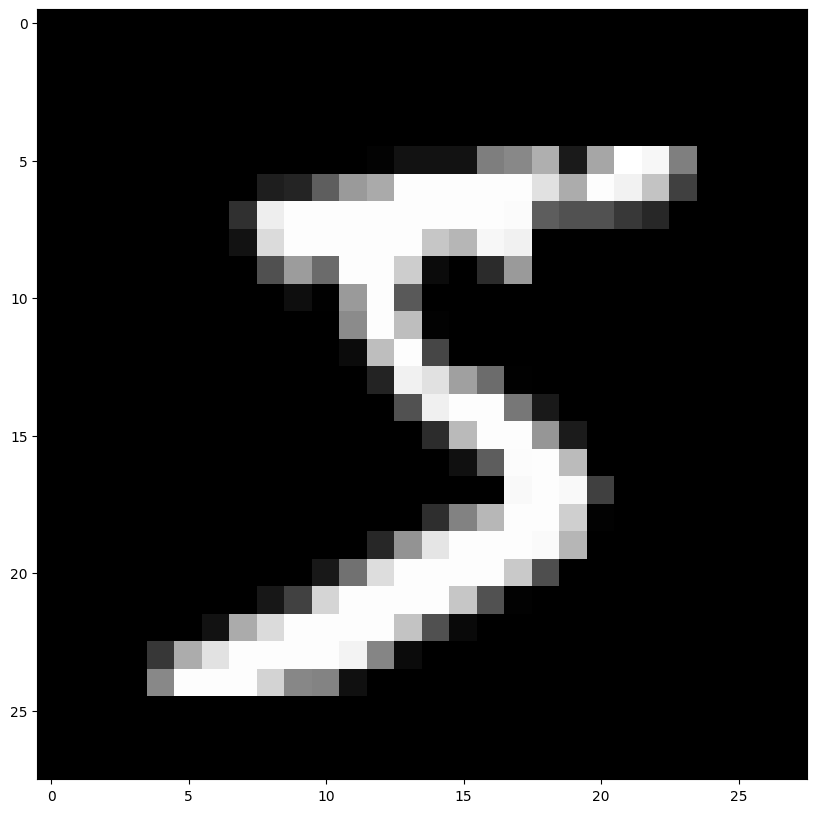

In [69]:
# Visualization

print(mnist_dataset[0][1]) # label
print(mnist_dataset[0][0].shape) # shape of tensor
print(mnist_dataset[0][0]) # tensor

plt.figure(figsize=(10,10))
plt.imshow(to_pil_image(mnist_dataset[0][0]), cmap='gray')

#### Noise and Context Mask

_ts shape:  torch.Size([1])
_ts:  tensor([306])
noise shape:  torch.Size([1, 28, 28])
noise[0][0][0]:  tensor(-0.1289)
sqrtab[_ts, None, None, None]:  tensor([[[[0.3043]]]])
sqrtmab[_ts, None, None, None]:  tensor([[[[0.9526]]]])
x_t shape:  torch.Size([1, 1, 28, 28])
x_t[0][0][0][0]:  tensor(-0.1228)  / noise[0][0][0]:  tensor(-0.1289)  / _ts[0]:  tensor(306)
context_mask:  tensor([1.])
context_mask shape:  torch.Size([1])
c:  tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
new c (flip) = c * context_mask:  tensor([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]])


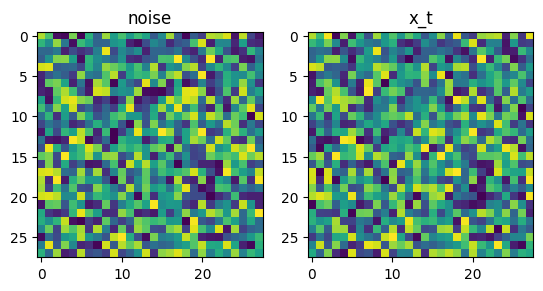

In [13]:
_ts = torch.randint(1, n_T+1, (x.shape[0],))  # t ~ Uniform(0, n_T)
noise = torch.randn_like(x)  # eps ~ N(0, 1)

print("_ts shape: ", _ts.shape)
print("_ts: ", _ts)

print("noise shape: ", noise.shape)
print("noise[0][0][0]: ", noise[0][0][0])

# plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(noise))
plt.title('noise')

betas=(1e-4, 0.02)
beta1, beta2 = betas[0], betas[1]
beta_t = (beta2 - beta1) * torch.arange(0, n_T + 1, dtype=torch.float32) / n_T + beta1
sqrt_beta_t = torch.sqrt(beta_t)
alpha_t = 1 - beta_t
log_alpha_t = torch.log(alpha_t)
alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
sqrtab = torch.sqrt(alphabar_t)
sqrtmab = torch.sqrt(1 - alphabar_t)
mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

x_t = (
    sqrtab[_ts, None, None, None] * x
    + sqrtmab[_ts, None, None, None] * noise
)
print("sqrtab[_ts, None, None, None]: ", sqrtab[_ts, None, None, None])
print("sqrtmab[_ts, None, None, None]: ", sqrtmab[_ts, None, None, None]) 
print("x_t shape: ", x_t.shape)
# print("x_t: ", x_t)
print("x_t[0][0][0][0]: ", x_t[0][0][0][0], " / noise[0][0][0]: ", noise[0][0][0], " / _ts[0]: ", _ts[0])

plt.subplot(1,2,2)
plt.imshow(to_pil_image(x_t[0][0]))
plt.title('x_t')

# dropout context with some probability
drop_prob=0.1
y_tensor = torch.Tensor([y])
context_mask = torch.bernoulli(torch.zeros_like(y_tensor) + drop_prob)
print("context_mask: ", context_mask)
print("context_mask shape: ", context_mask.shape)

# convert context to one hot embedding
c = nn.functional.one_hot(y_tensor.to(torch.int64), num_classes=n_classes).type(torch.float)
print("c: ", c)

# mask out context if context_mask == 1
context_mask = context_mask[:, None]
context_mask = context_mask.repeat(1, n_classes)
context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
c = c * context_mask
print("new c (flip) = c * context_mask: ", c)


In [14]:
# self.nn_model(x_t, c, _ts / self.n_T, context_mask)
# def forward(self, x, c, t, context_mask):
    # x is (noisy) image, c is context label, t is timestep, 
    # context_mask says which samples to block the context on

##### self.init_conv = ResidualConvBlock(in_channels=1, n_feat=128, is_res=True)

x_t1: torch.Size([1, 128, 28, 28])
x_t2: torch.Size([1, 128, 28, 28])
x_t3: torch.Size([1, 128, 28, 28])
x_t1 channels


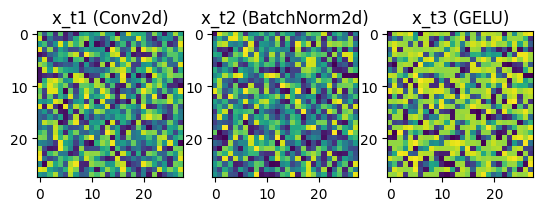

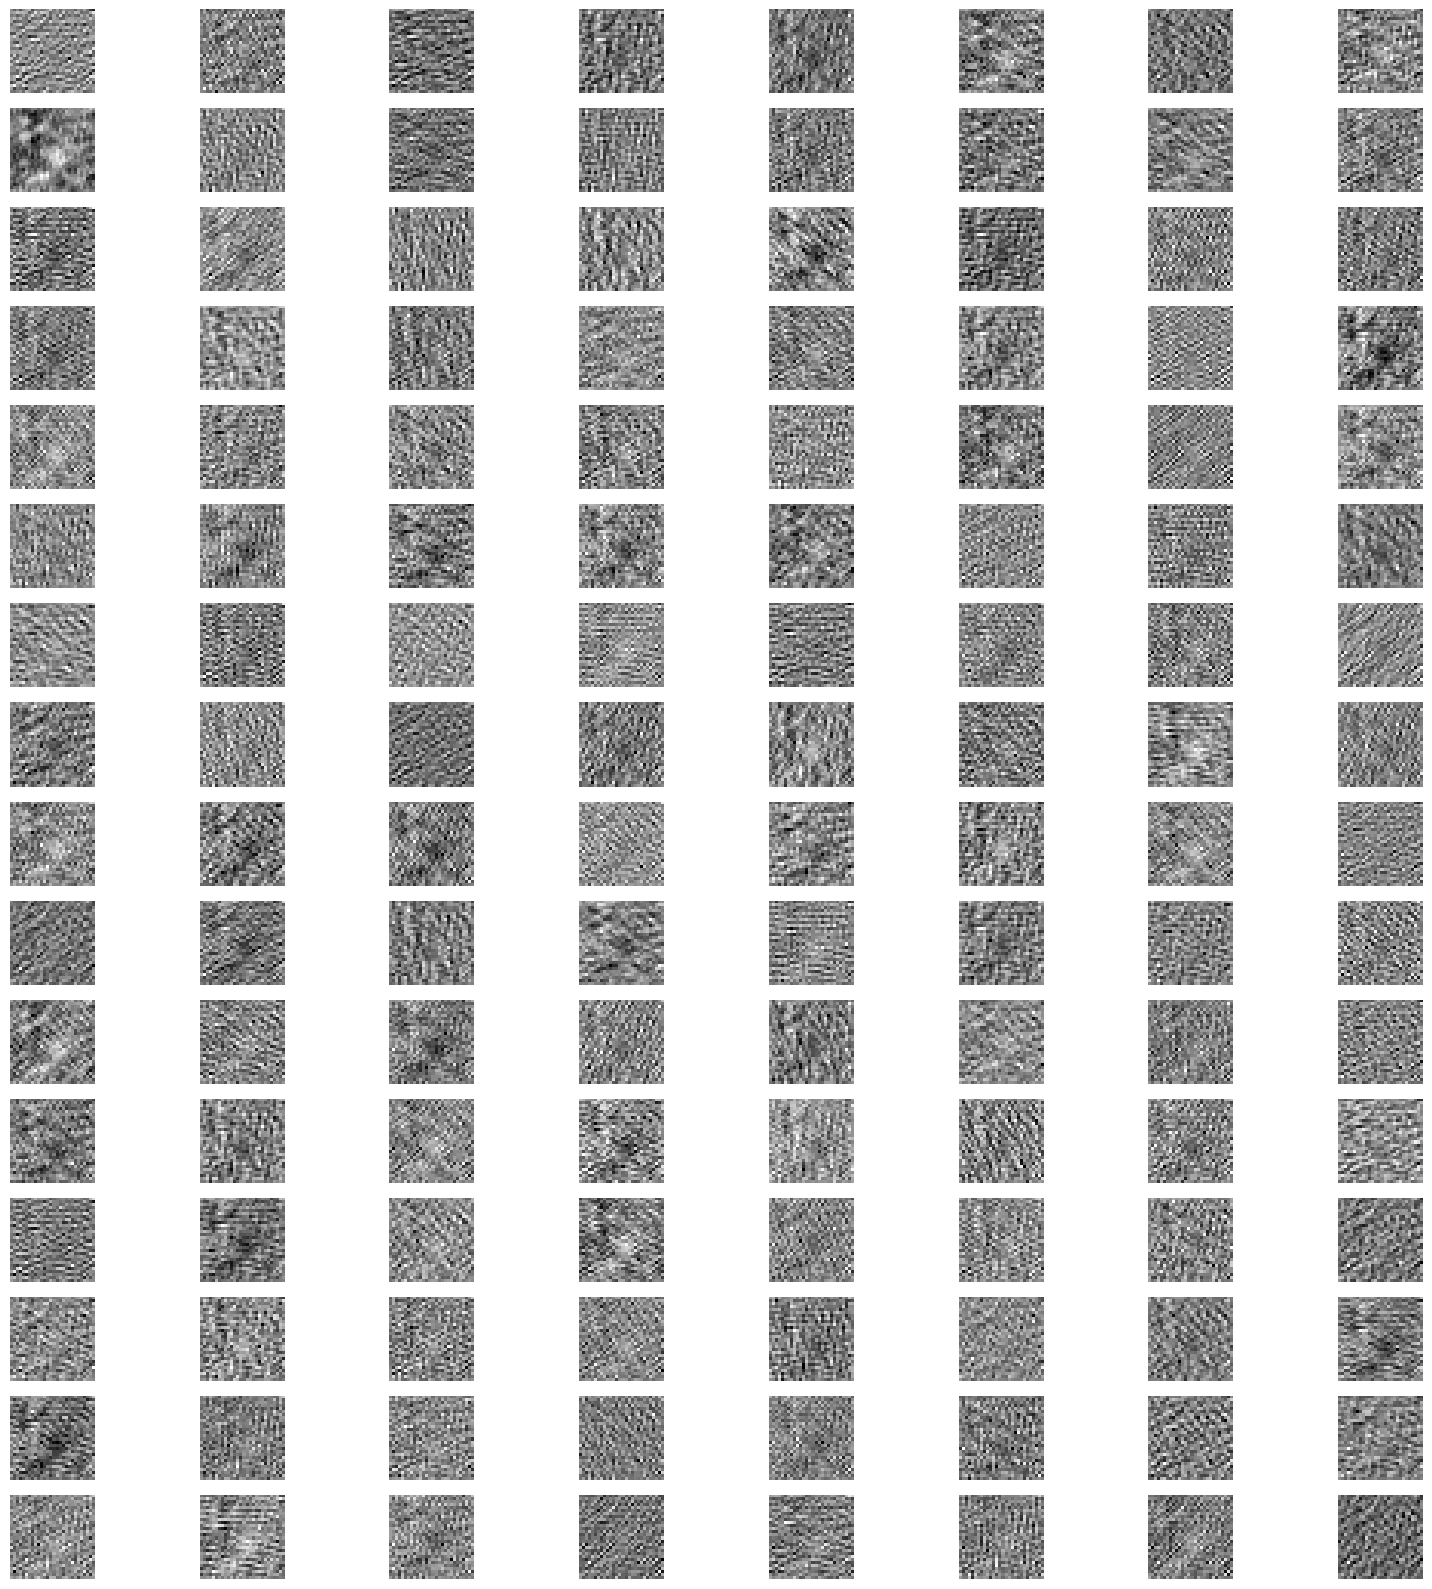

x_t2 channels


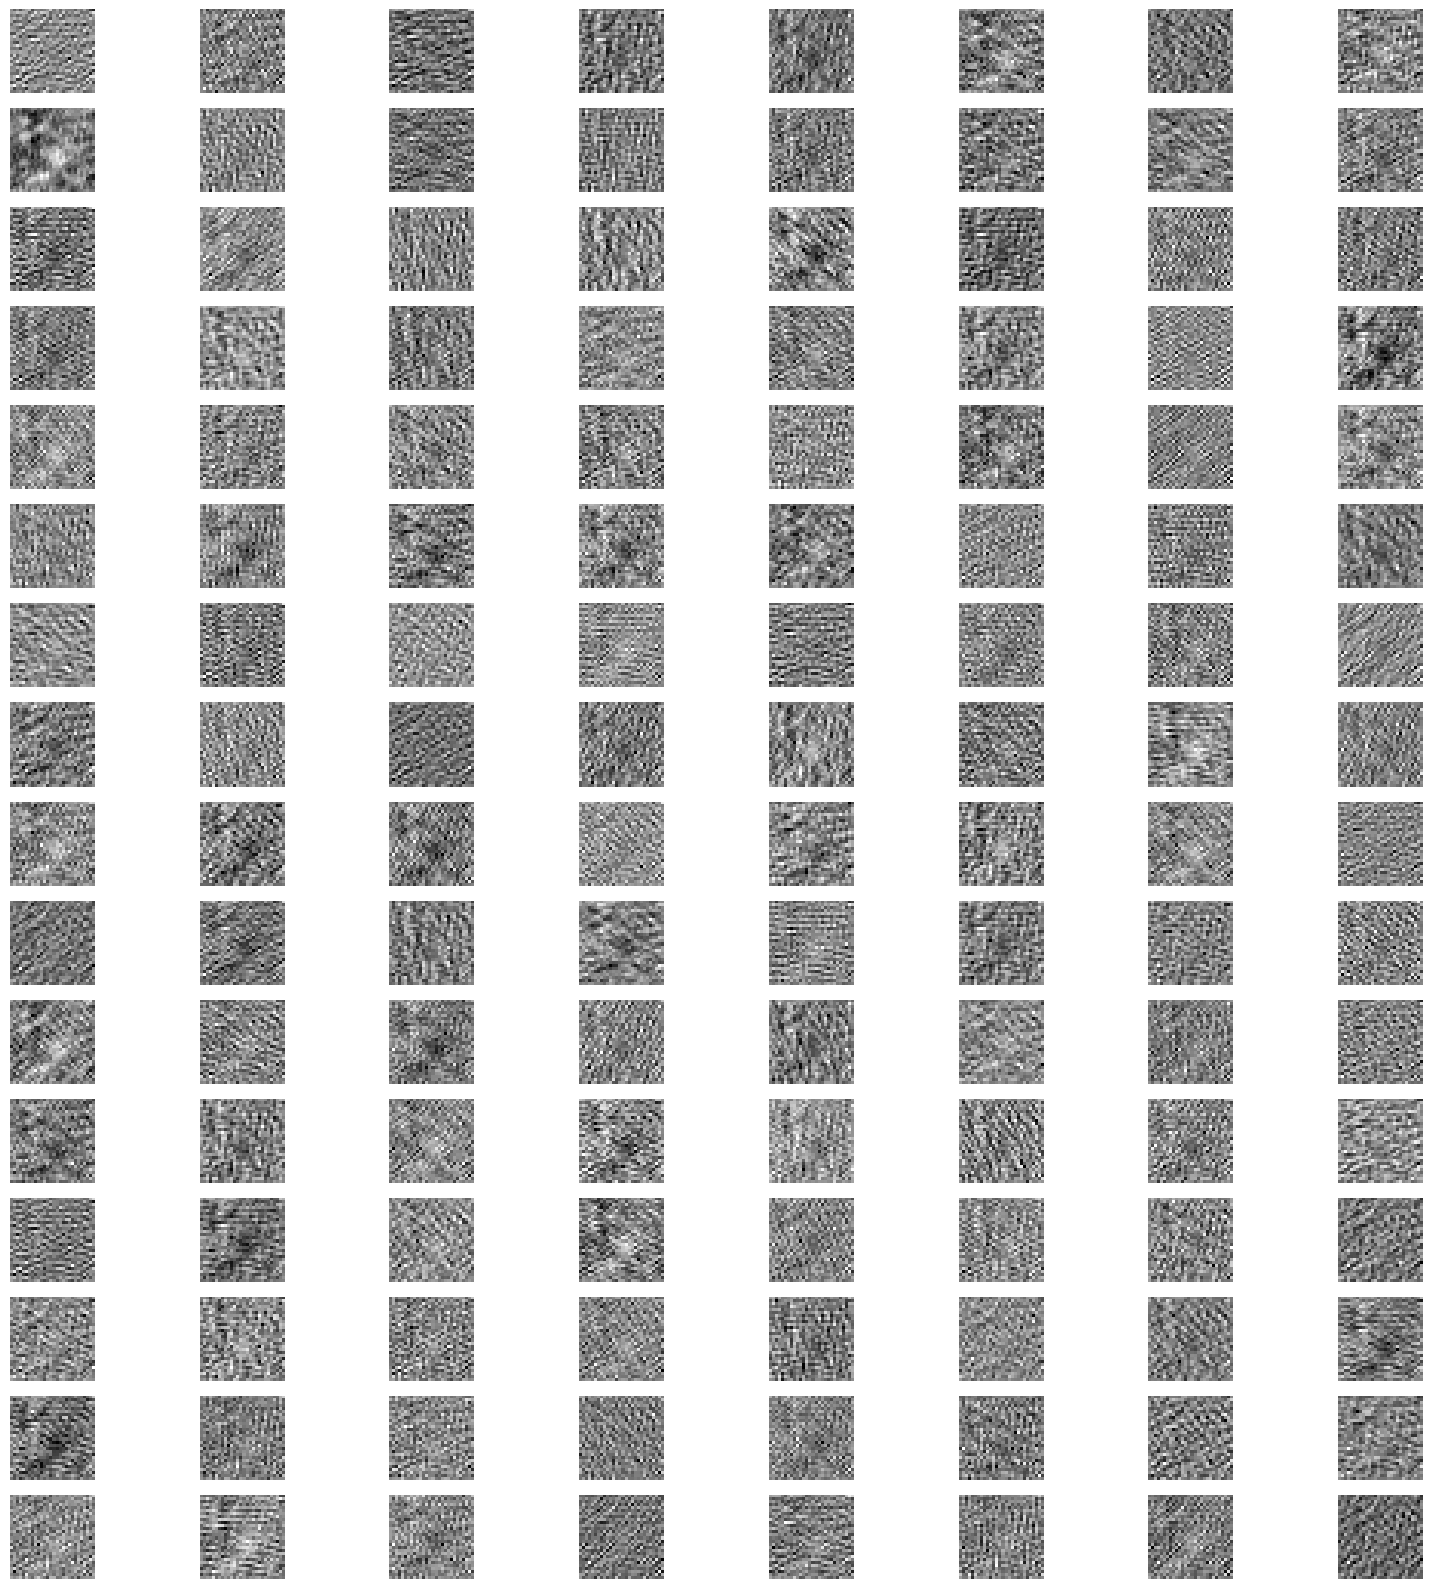

x_t3 channels


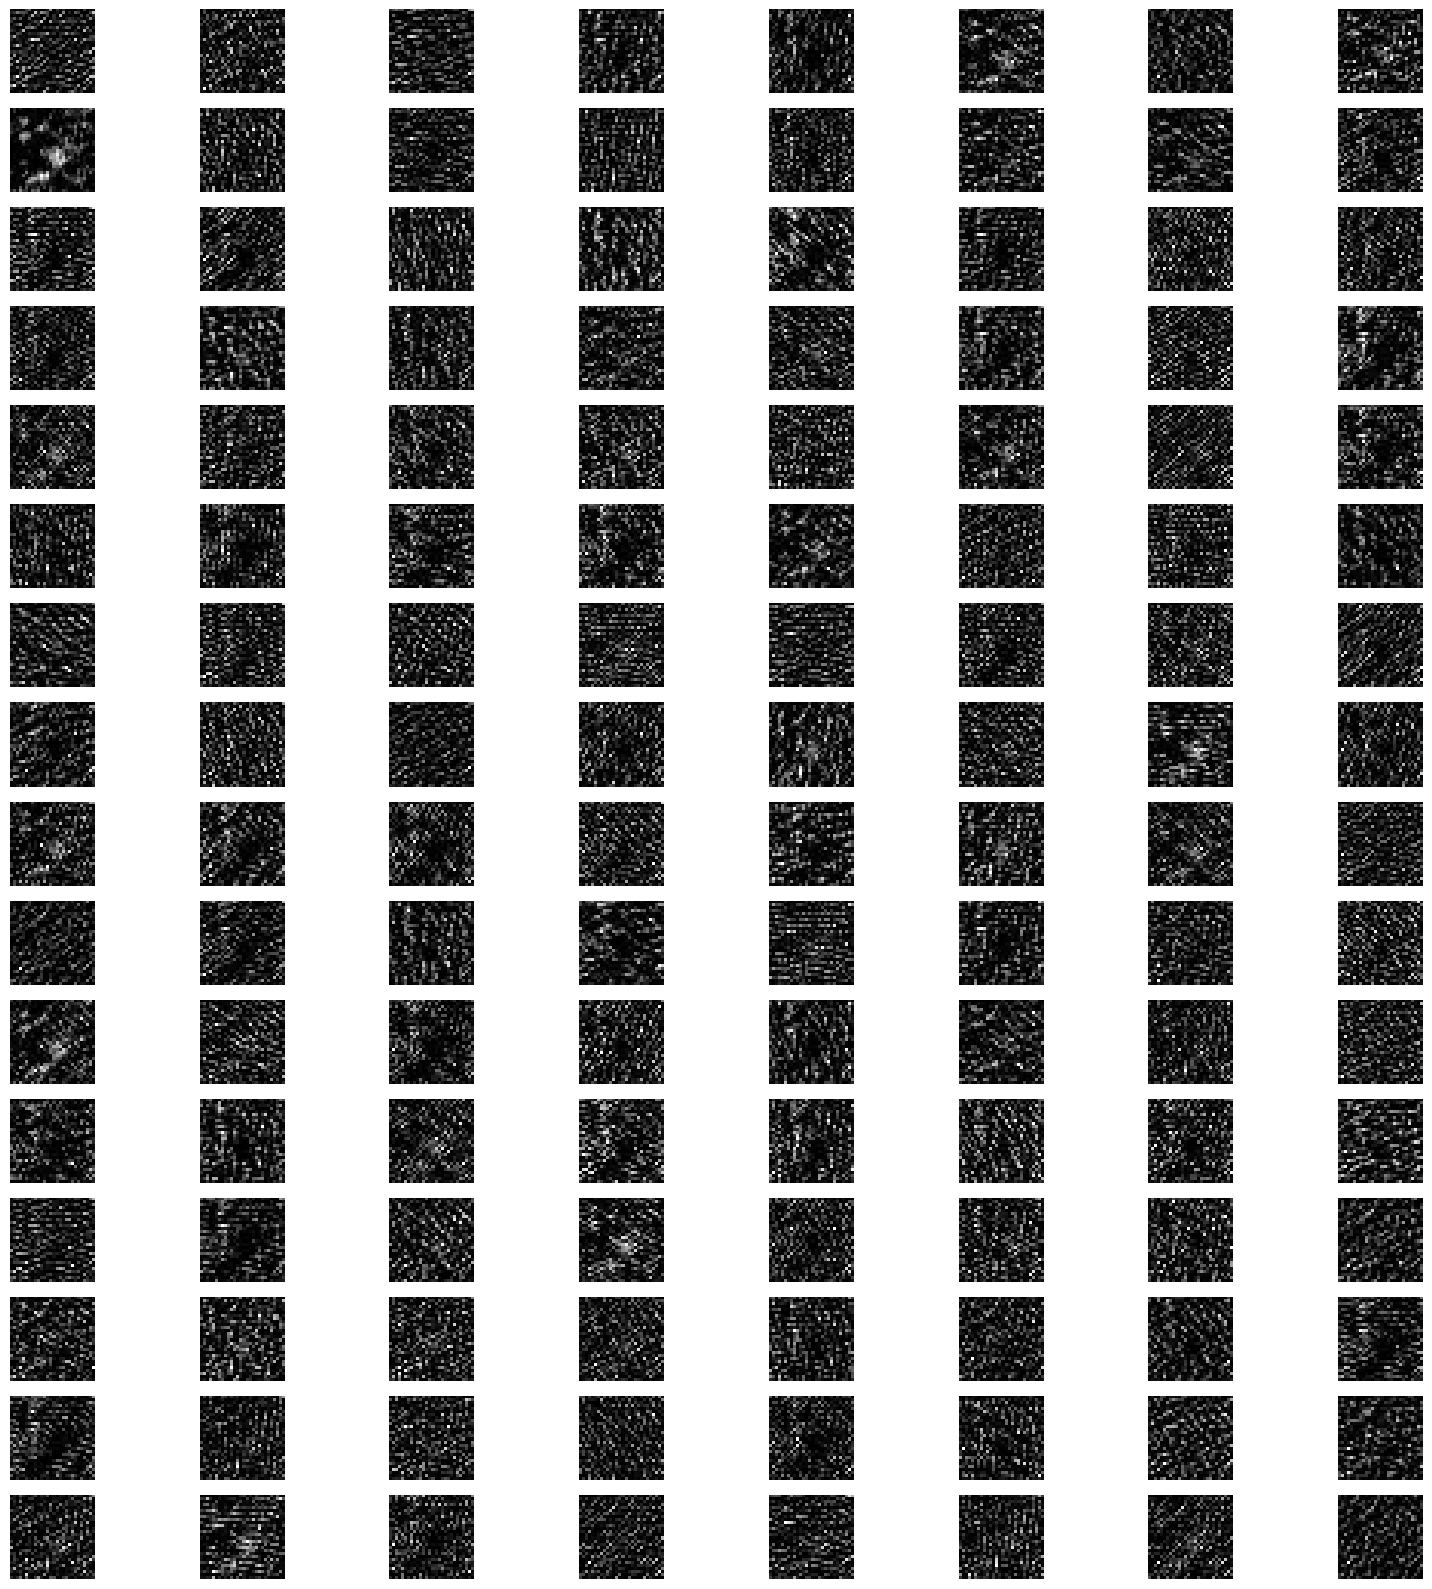

In [15]:
p1 = nn.Conv2d(1, n_feat, 3, 1, 1) # 128
p2 = nn.BatchNorm2d(n_feat) # 128
p3 = nn.GELU()

x_t1 = p1(x_t)
print("x_t1:", x_t1.shape)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(x_t1[0][0]))
plt.title('x_t1 (Conv2d)')

x_t2 = p2(x_t1)
print("x_t2:", x_t2.shape)
plt.subplot(1,3,2)
plt.imshow(to_pil_image(x_t2[0][0]))
plt.title('x_t2 (BatchNorm2d)')

x_t3 = p3(x_t2)
print("x_t3:", x_t3.shape)
plt.subplot(1,3,3)
plt.imshow(to_pil_image(x_t3[0][0]))
plt.title('x_t3 (GELU)')

print("x_t1 channels")
channel_visualization("", x_t1)
print("x_t2 channels")
channel_visualization("", x_t2)
print("x_t3 channels")
channel_visualization("", x_t3)

x_t4: torch.Size([1, 128, 28, 28])
x_t5: torch.Size([1, 128, 28, 28])
x_t6: torch.Size([1, 128, 28, 28])
x_t4 channels


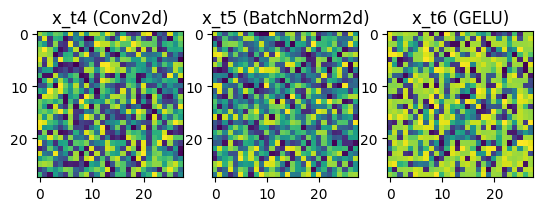

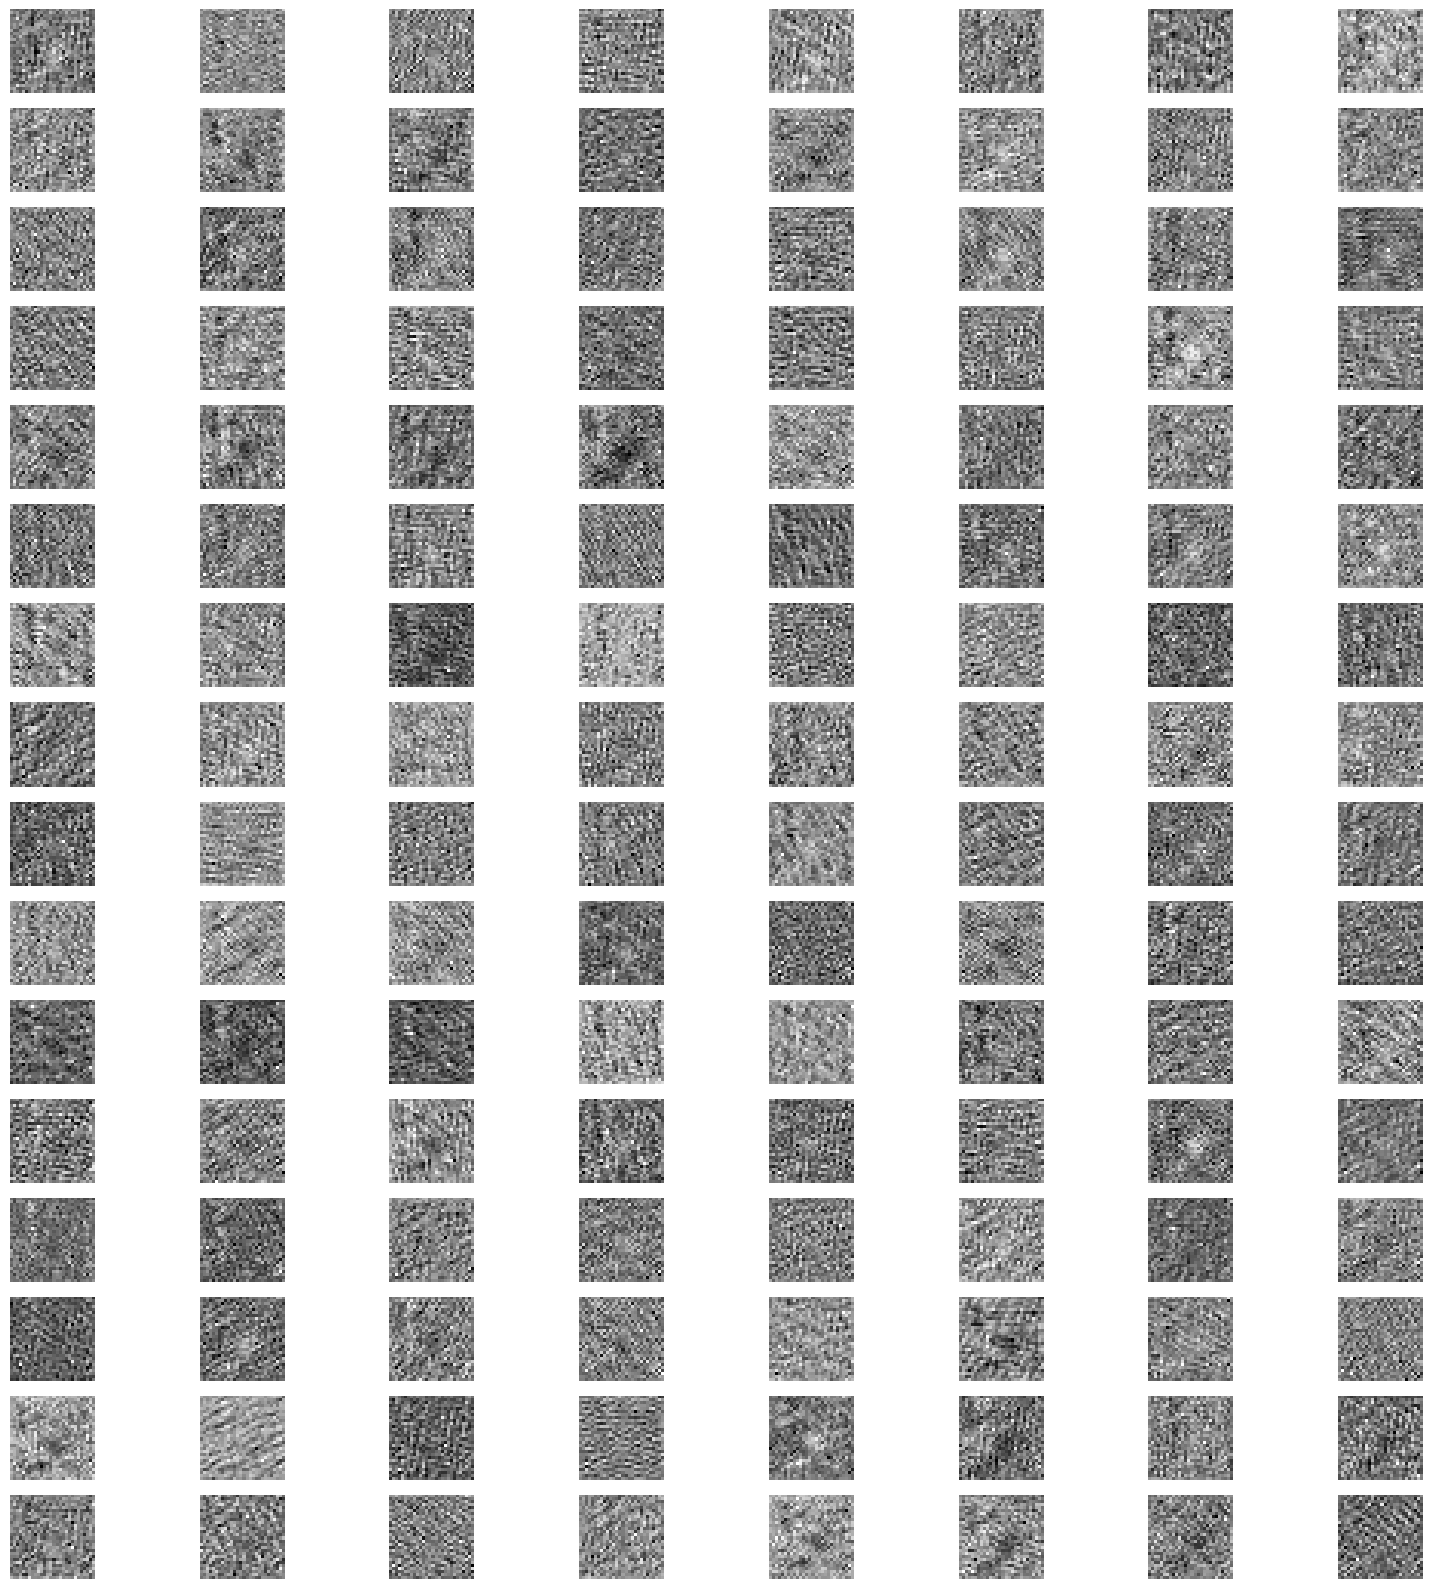

x_t5 channels


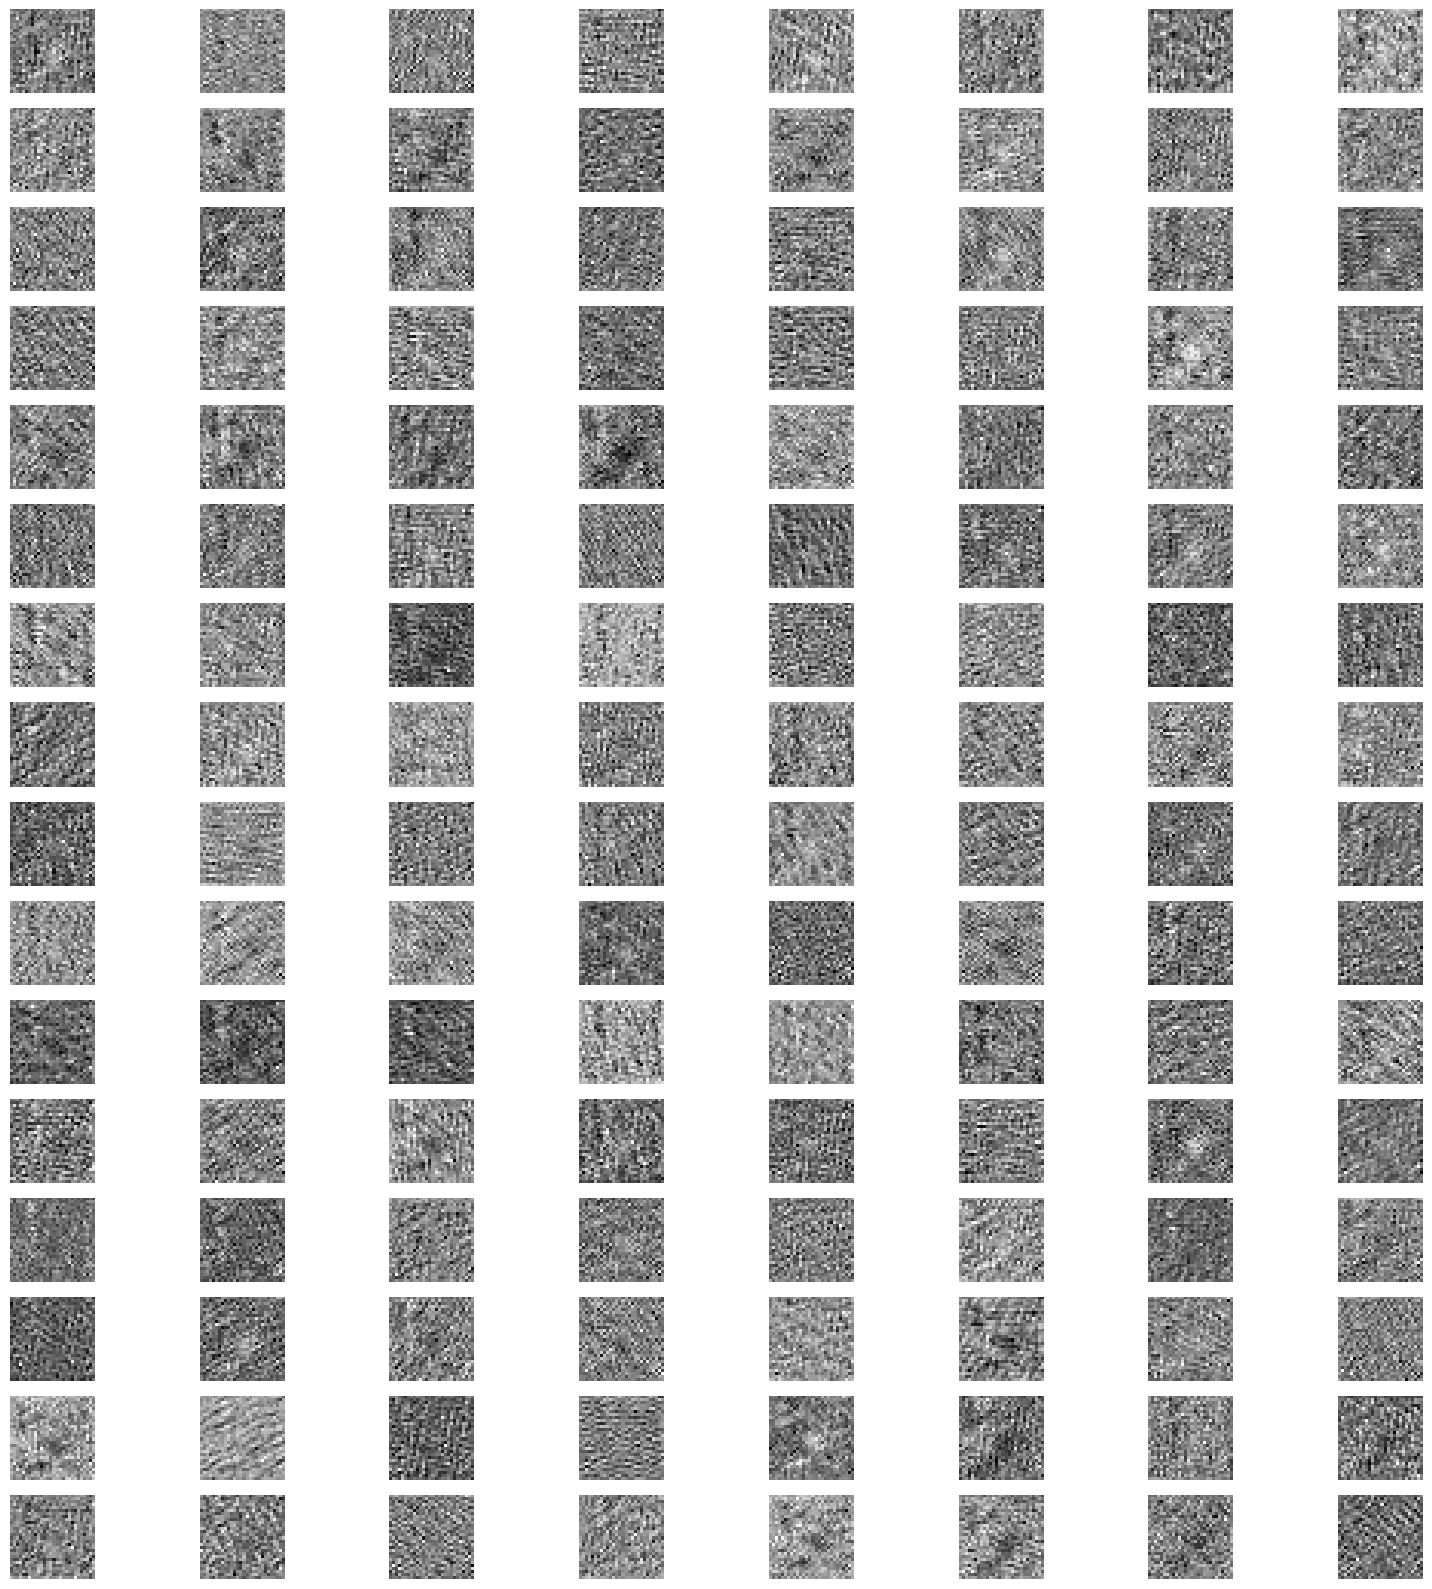

x_t6 channels


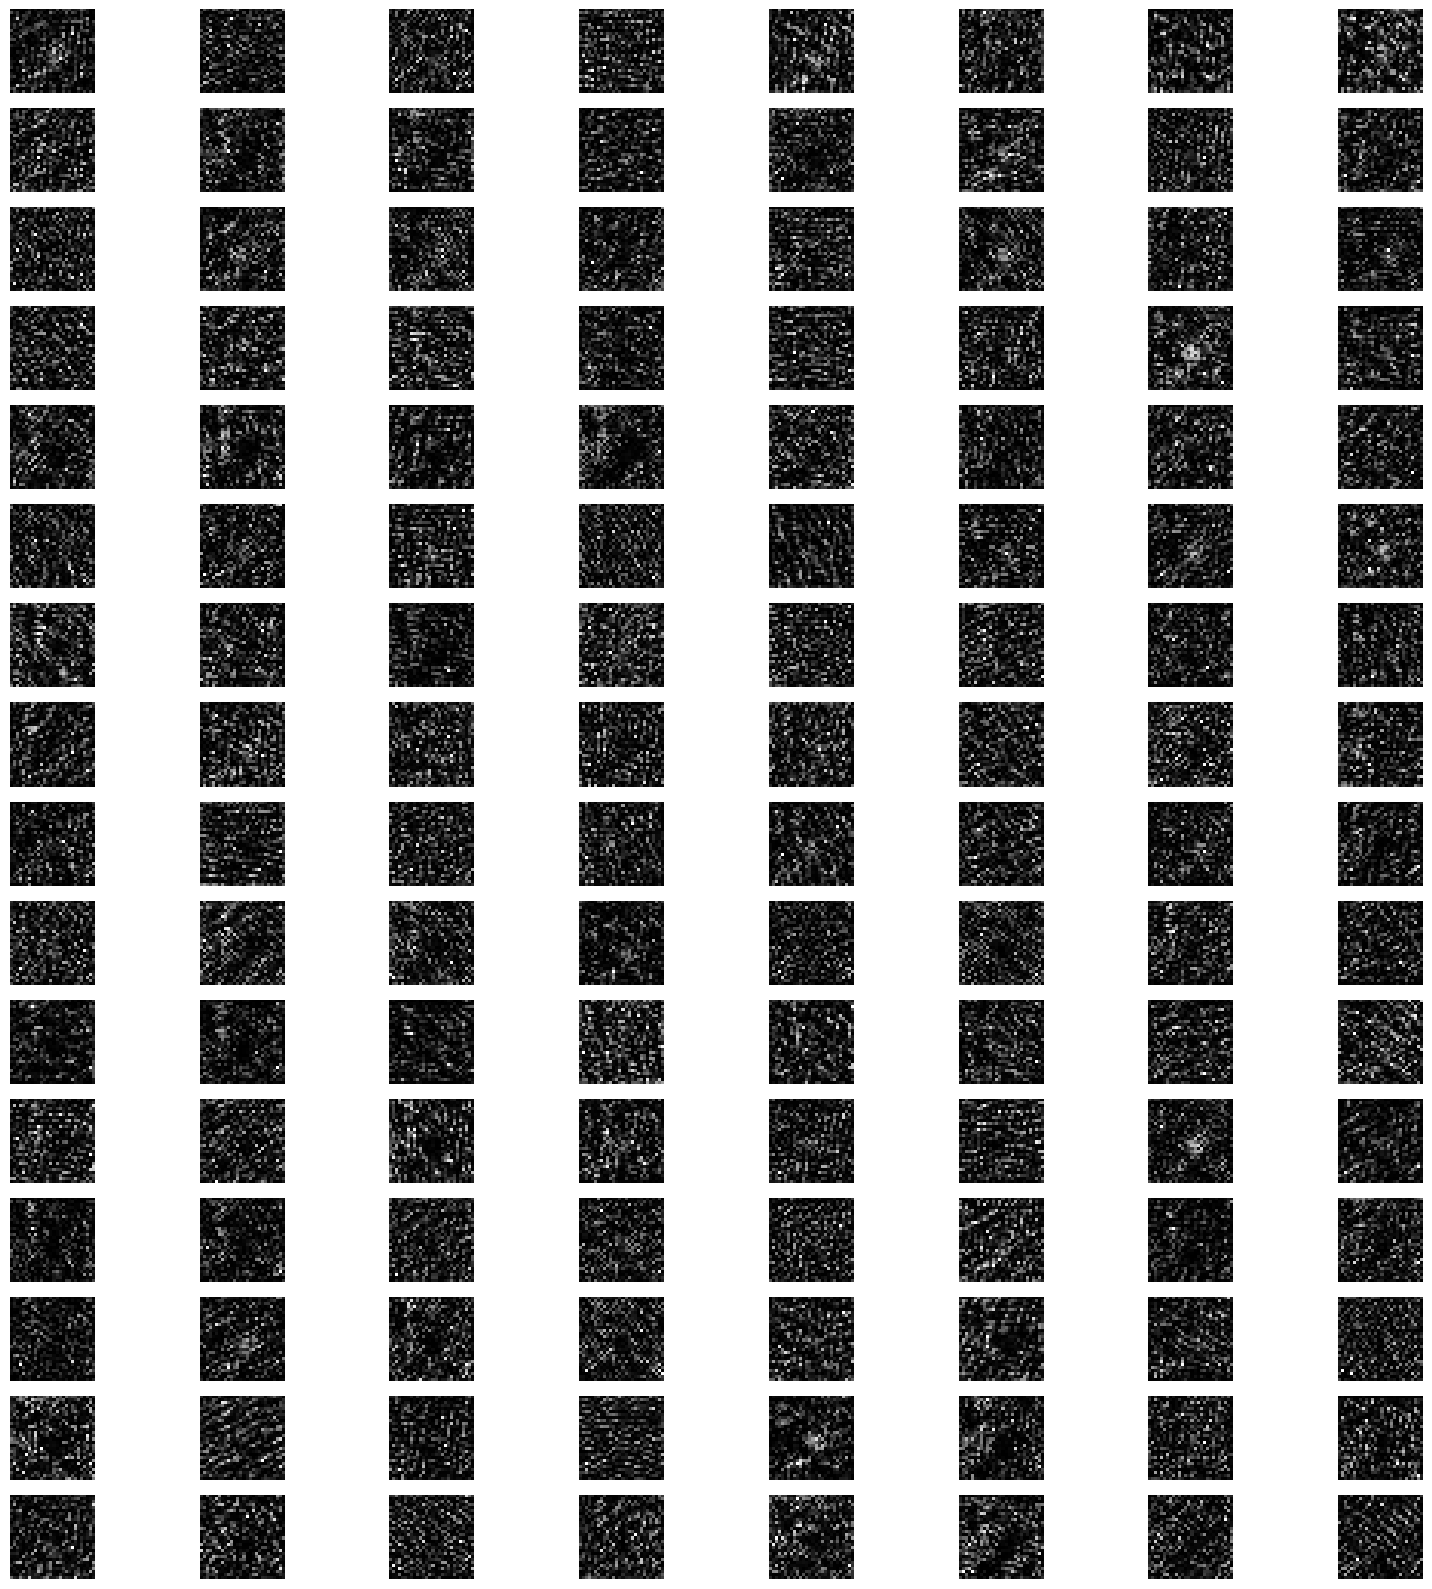

In [16]:
p4 = nn.Conv2d(n_feat, n_feat, 3, 1, 1) # 128
p5 = nn.BatchNorm2d(n_feat) # 128
p6 = nn.GELU()

x_t4 = p4(x_t3)
print("x_t4:", x_t4.shape)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(x_t4[0][0]))
plt.title('x_t4 (Conv2d)')

x_t5 = p5(x_t4)
print("x_t5:", x_t5.shape)
plt.subplot(1,3,2)
plt.imshow(to_pil_image(x_t5[0][0]))
plt.title('x_t5 (BatchNorm2d)')

x_t6 = p6(x_t5)
print("x_t6:", x_t6.shape)
plt.subplot(1,3,3)
plt.imshow(to_pil_image(x_t6[0][0]))
plt.title('x_t6 (GELU)')

print("x_t4 channels")
channel_visualization("", x_t4)
print("x_t5 channels")
channel_visualization("", x_t5)
print("x_t6 channels")
channel_visualization("", x_t6)

init_conv: torch.Size([1, 128, 28, 28])


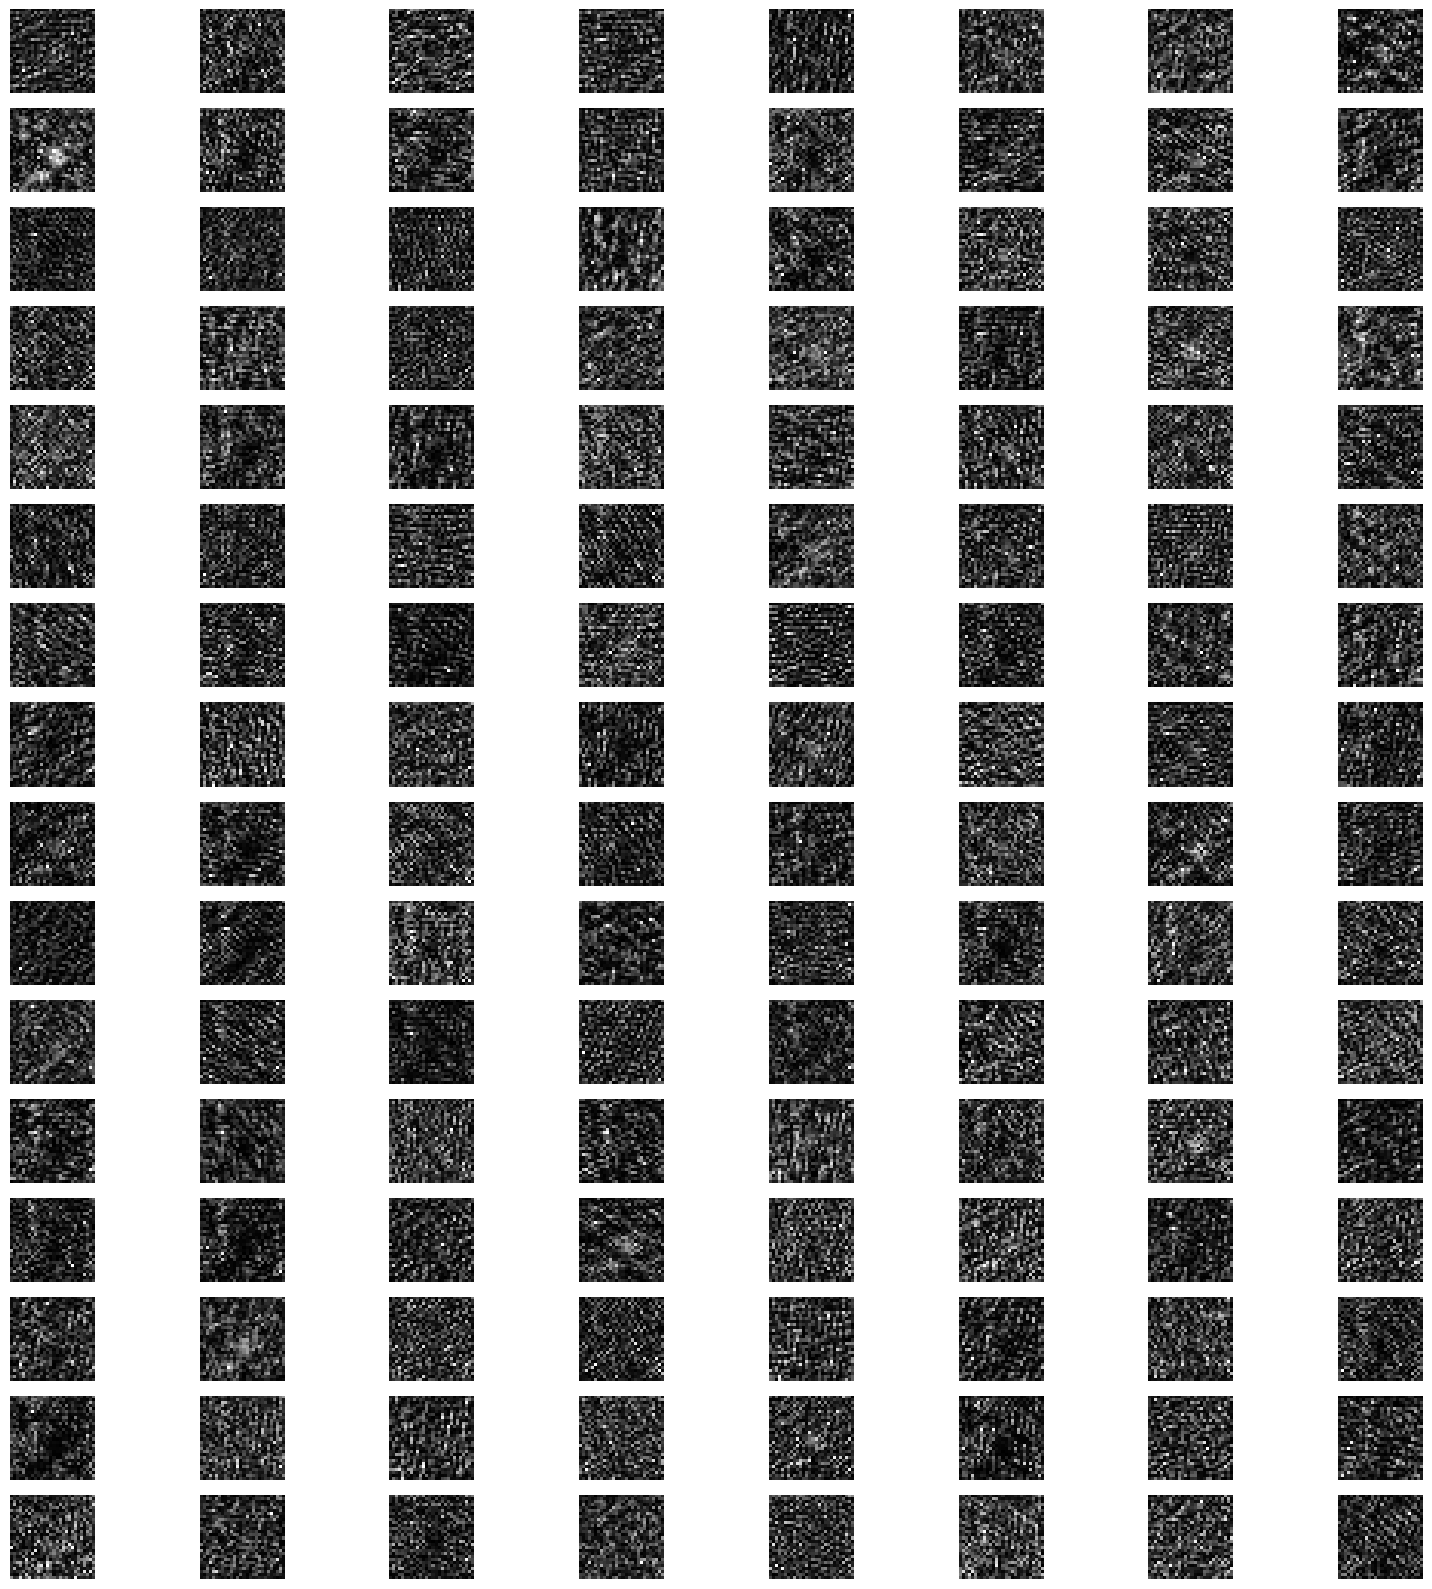

tensor([-0.0241, -0.2950, -0.2503, -0.2401, -0.1675,  0.3904,  1.1182, -0.2177,
        -0.1066, -0.2754, -0.1654, -0.1354, -0.0359,  1.7544, -0.2225,  1.1246,
        -0.3390,  0.8776,  0.4132,  0.5989, -0.0417,  0.0175,  0.3533,  0.9749,
         1.2064, -0.0533, -0.2028, -0.1634], grad_fn=<SelectBackward0>)
init_conv/1.414: torch.Size([1, 128, 28, 28])


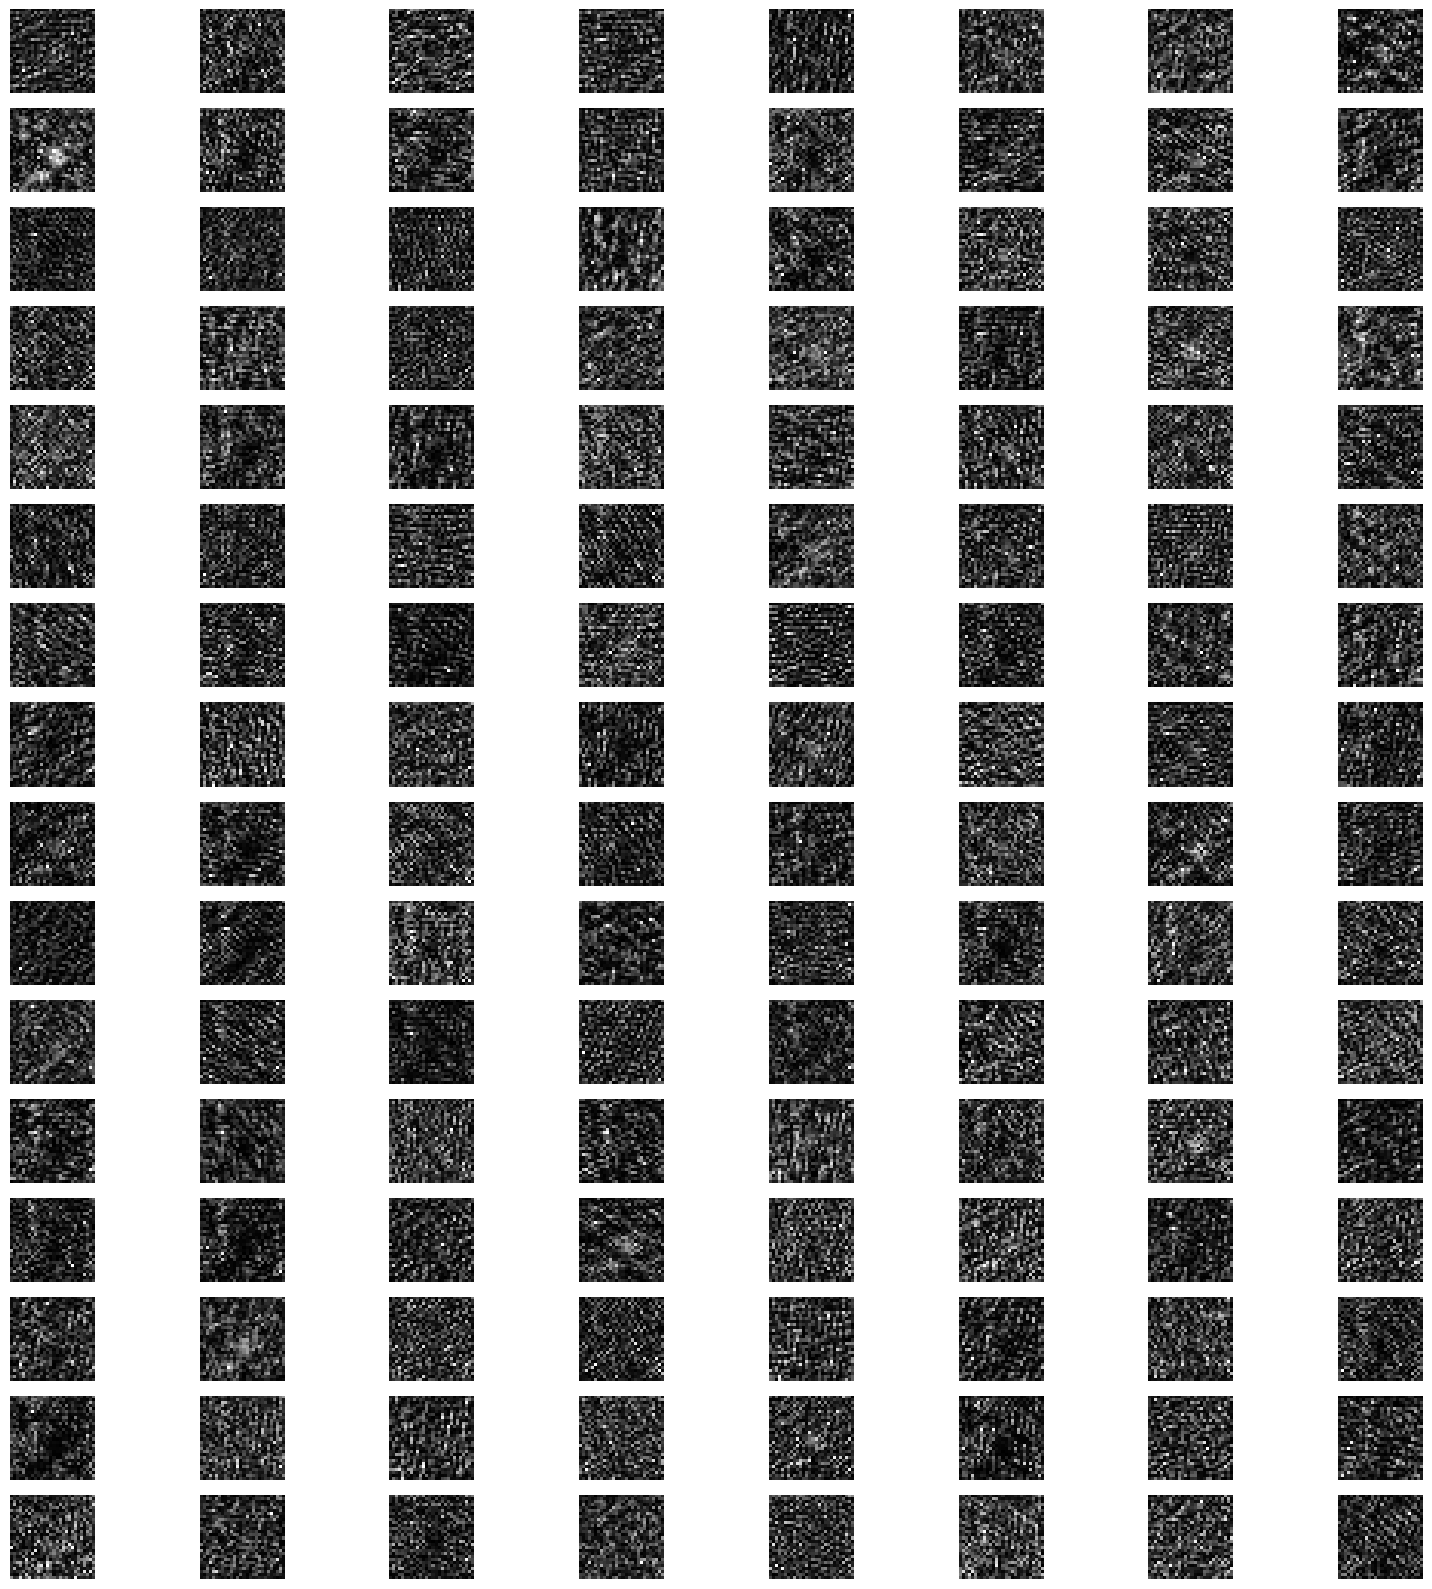

tensor([-0.0171, -0.2086, -0.1770, -0.1698, -0.1184,  0.2761,  0.7908, -0.1540,
        -0.0754, -0.1948, -0.1170, -0.0957, -0.0254,  1.2407, -0.1574,  0.7953,
        -0.2398,  0.6206,  0.2922,  0.4236, -0.0295,  0.0123,  0.2499,  0.6895,
         0.8532, -0.0377, -0.1434, -0.1155], grad_fn=<SelectBackward0>)


In [17]:
# not same channel
init_conv = x_t3 + x_t6
print("init_conv:", init_conv.shape)
channel_visualization("", init_conv)
print(init_conv[0][0][0])

# He 초기화(Kaiming 초기화)
init_conv = init_conv/1.414
print("init_conv/1.414:", init_conv.shape)
channel_visualization("", init_conv)
print(init_conv[0][0][0])

#### UnetDown

##### self.down1 = UnetDown(n_feat=128, n_feat=128)

down1: torch.Size([1, 128, 14, 14])


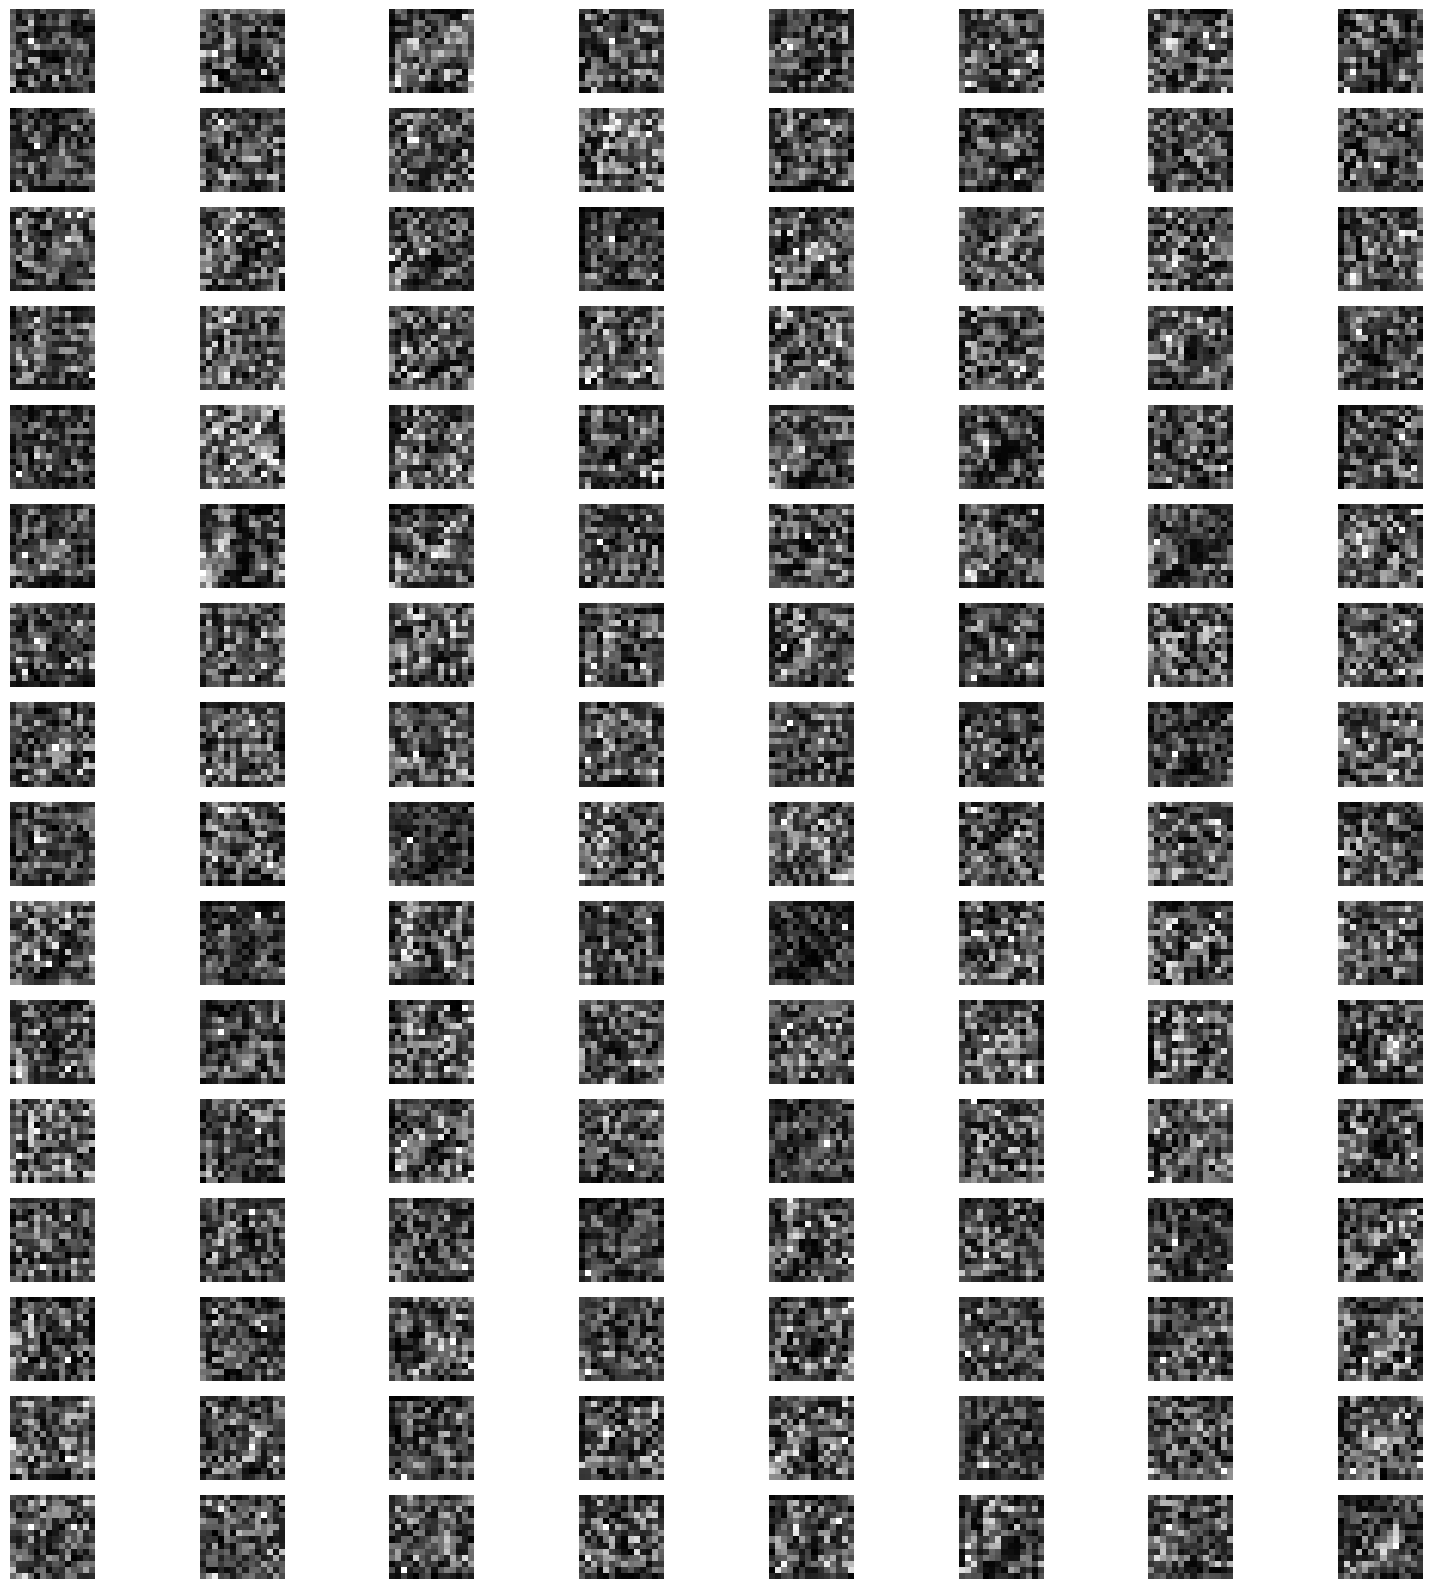

In [18]:
res_conv1 = nn.Sequential(
    nn.Conv2d(n_feat, n_feat, 3, 1, 1),
    nn.BatchNorm2d(n_feat),
    nn.GELU(),
)
res_conv2 = nn.Sequential(
    nn.Conv2d(n_feat, n_feat, 3, 1, 1),
    nn.BatchNorm2d(n_feat),
    nn.GELU(),
)
unet_down1 = nn.MaxPool2d(2)

down1 = unet_down1(res_conv2(res_conv1(init_conv)))
print("down1:", down1.shape)
channel_visualization("", down1)

##### self.down2 = UnetDown(n_feat=128, 2 * n_feat=256)

down1: torch.Size([1, 256, 7, 7])


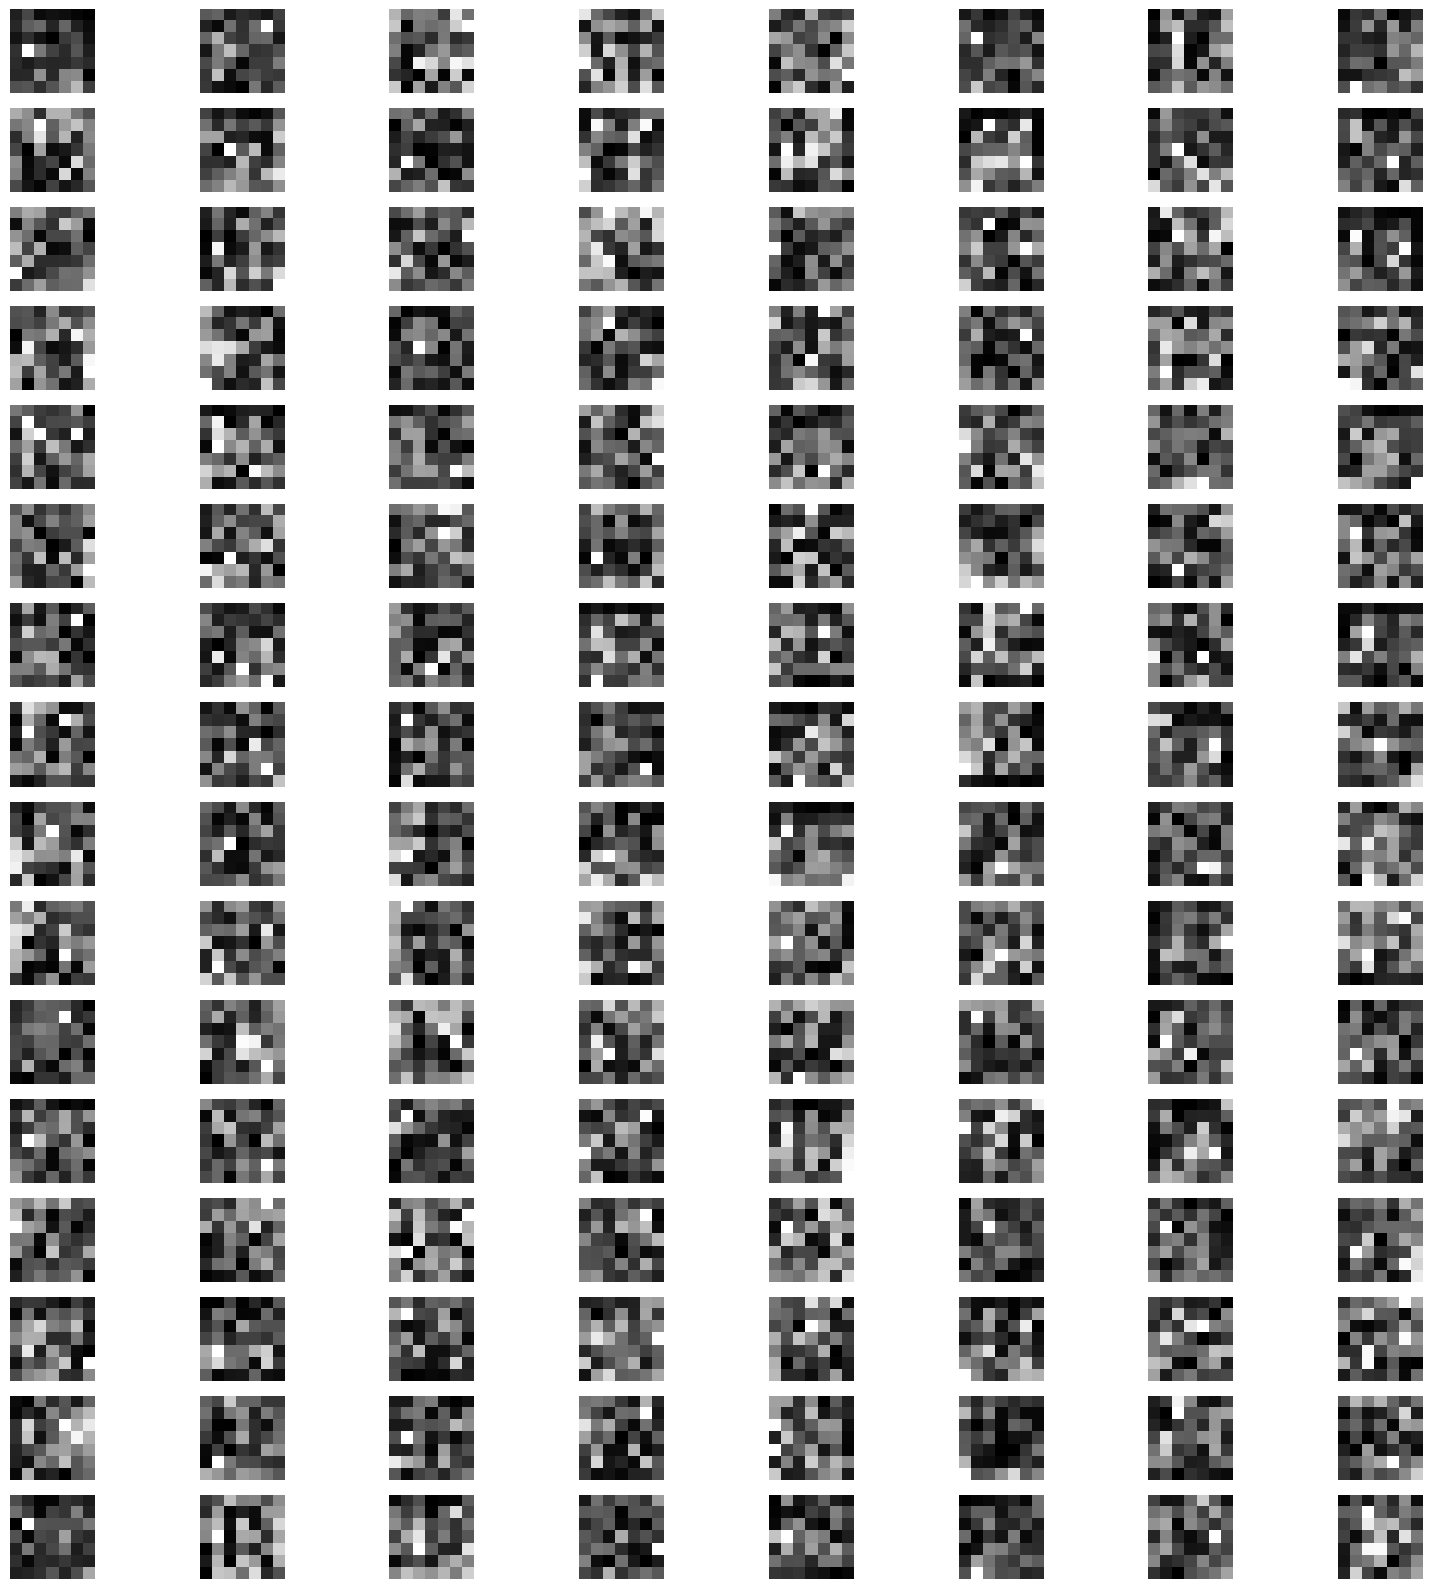

In [19]:
res_conv1 = nn.Sequential(
    nn.Conv2d(n_feat, 2 * n_feat, 3, 1, 1),
    nn.BatchNorm2d(2 * n_feat),
    nn.GELU(),
)
res_conv2 = nn.Sequential(
    nn.Conv2d(2 * n_feat, 2 * n_feat, 3, 1, 1),
    nn.BatchNorm2d(2 * n_feat),
    nn.GELU(),
)
unet_down2 = nn.MaxPool2d(2)

down2 = unet_down2(res_conv2(res_conv1(down1)))
print("down1:", down2.shape)
channel_visualization("", down2)

##### self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

hiddenvec: torch.Size([1, 256, 1, 1])


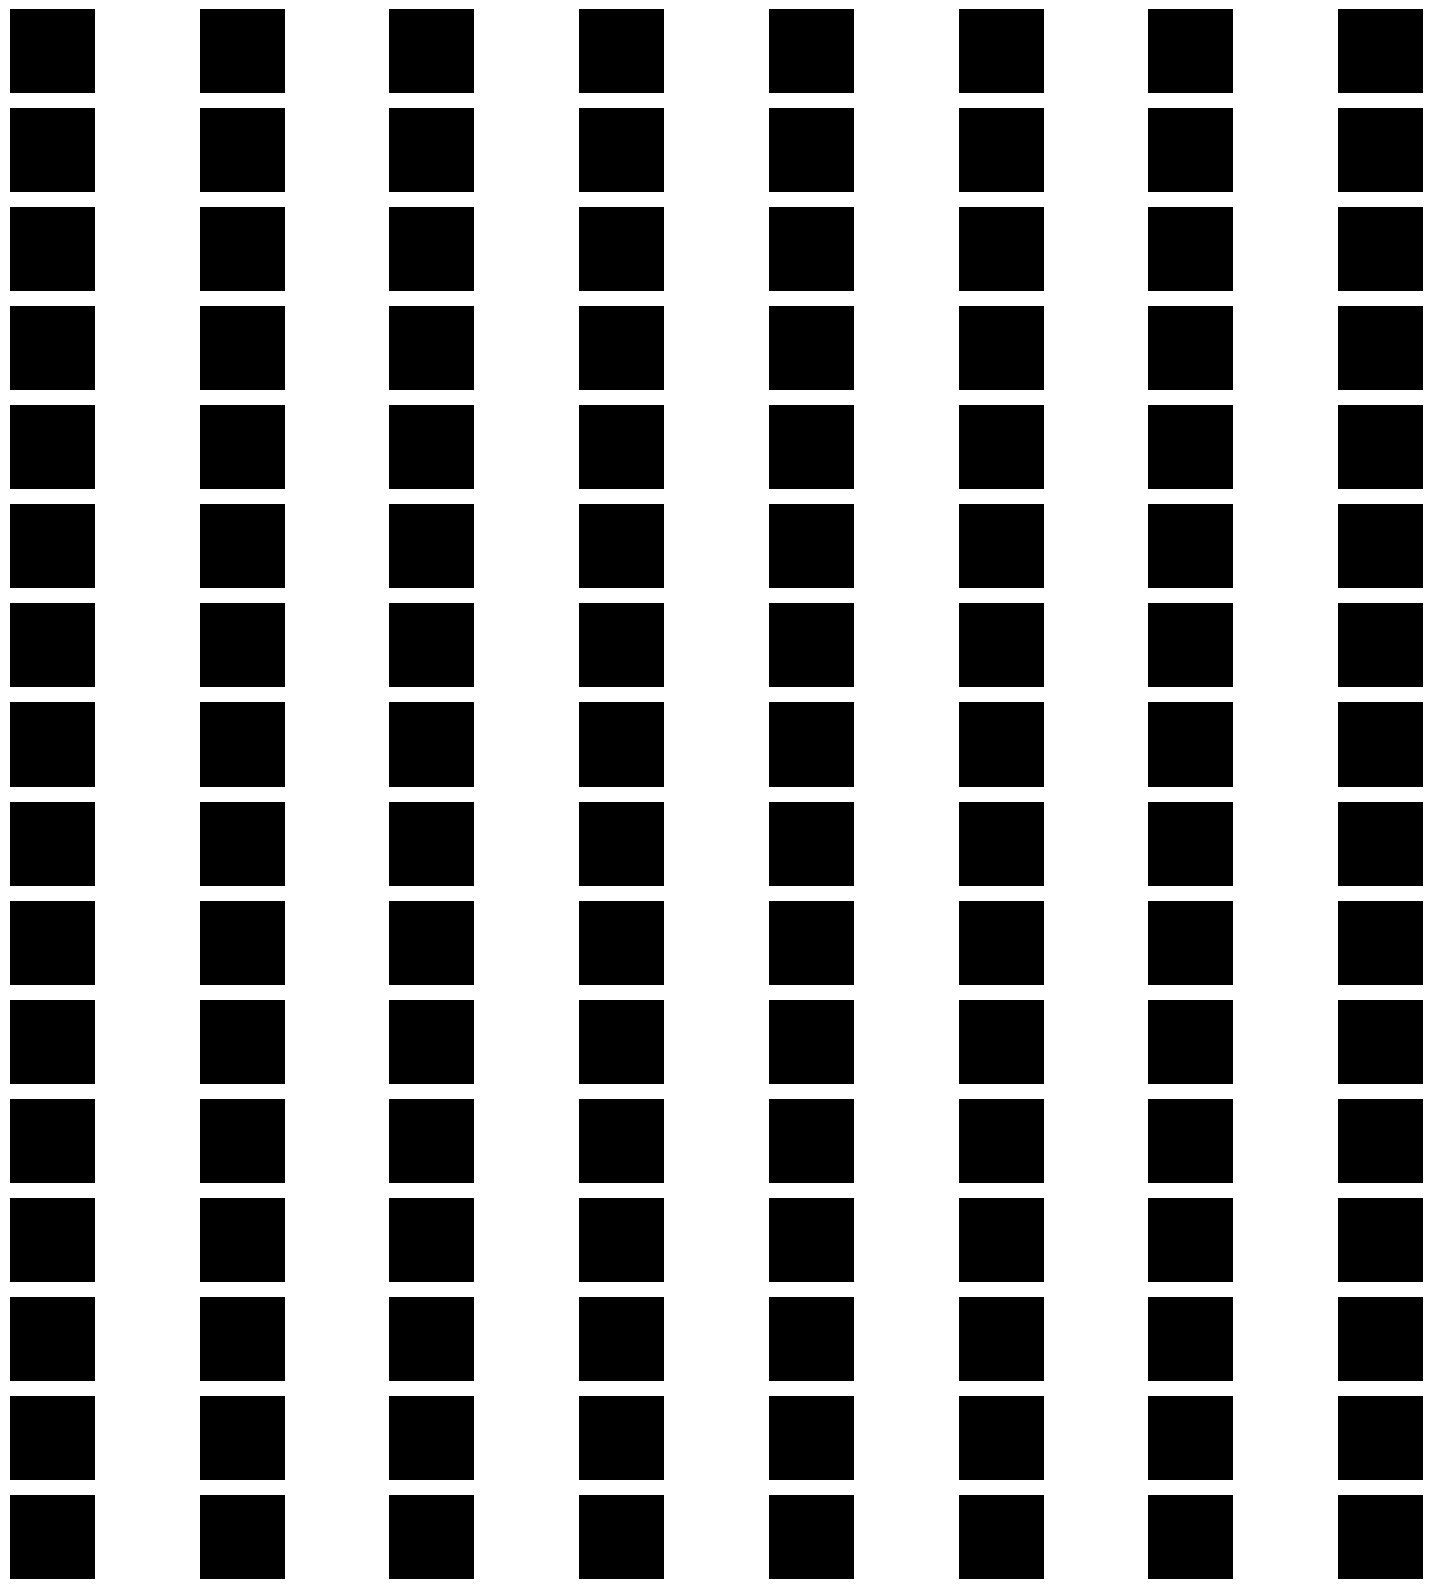

tensor([[[[0.6344]],

         [[0.7814]],

         [[0.7060]],

         [[0.7677]],

         [[0.8001]],

         [[0.7966]],

         [[0.6695]],

         [[0.7513]],

         [[0.6574]],

         [[0.7812]],

         [[0.7304]],

         [[0.6393]],

         [[0.7456]],

         [[0.7000]],

         [[0.7435]],

         [[0.6681]],

         [[0.7530]],

         [[0.7214]],

         [[0.7998]],

         [[0.7641]],

         [[0.6180]],

         [[0.7639]],

         [[0.7323]],

         [[0.6829]],

         [[0.7621]],

         [[0.7739]],

         [[0.7478]],

         [[0.7445]],

         [[0.7643]],

         [[0.7037]],

         [[0.6971]],

         [[0.8131]],

         [[0.7947]],

         [[0.7205]],

         [[0.7122]],

         [[0.7955]],

         [[0.7678]],

         [[0.7708]],

         [[0.6828]],

         [[0.8148]],

         [[0.7803]],

         [[0.7365]],

         [[0.7962]],

         [[0.6961]],

         [[0.7617]],

         [

In [20]:
to_vec = nn.Sequential(
    nn.AvgPool2d(7),
    nn.GELU(),
)

hiddenvec = to_vec(down2)
print("hiddenvec:", hiddenvec.shape)
channel_visualization("", hiddenvec)
print(hiddenvec)

#### EmbedFC

##### self.timeembed1 = EmbedFC(1, 2*n_feat=256)

In [21]:
# _ts = torch.randint(1, n_T+1, (x.shape[0],)) # t ~ Uniform(0, n_T) : 1부터 400까지 균등분포를 따르는 값을 배치차원의 크기로 생성
t = _ts / n_T
print("_ts: ", _ts, "| n_T: ", n_T, "| t(=_ts/n_T): ", t)

_ts:  tensor([306]) | n_T:  400 | t(=_ts/n_T):  tensor([0.7650])


In [22]:
input_dim, emb_dim = 1, 2*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("t.shape:", t.shape)
t1_view = t.view(-1, input_dim)
print("t1_view.shape:", t1_view.shape)
t1_embed = e1(t1_view)
print("t1_embed.shape (1 -> 256):", t1_embed.shape)
print(t1_embed)
t1_embed = e2(t1_embed)
print("t1_embed.shape (GELU):", t1_embed.shape)
print(t1_embed)
t1_embed = e3(t1_embed)
print("t1_embed.shape (256 -> 256):", t1_embed.shape)
print(t1_embed)

temb1 = t1_embed.view(-1, n_feat * 2, 1, 1)
print("temb1.shape:", temb1.shape)

t.shape: torch.Size([1])
t1_view.shape: torch.Size([1, 1])
t1_embed.shape (1 -> 256): torch.Size([1, 256])
tensor([[ 0.8116, -0.3448,  0.1855, -0.8141, -0.5990, -0.2134, -1.1601,  0.9820,
          1.1532, -0.7265, -0.5143,  0.4223,  0.0134,  0.9997,  0.4390,  0.3581,
          1.0685, -0.0379,  0.7306, -0.1855,  0.6564, -1.0916,  0.9008, -0.4204,
          0.5631, -0.2810, -0.1293,  0.9812,  0.2526, -0.4593,  0.3526, -1.0282,
         -0.0260, -1.1930, -0.7286, -1.0702,  0.7633, -0.2012,  1.1720,  1.0577,
          0.0684, -0.2555,  1.1216, -0.2292, -1.1697,  0.1436, -1.0007,  0.6622,
          0.4616,  0.4820,  0.2381, -0.4080,  0.6712,  0.4051,  0.6656,  0.0951,
          0.9411,  0.1948,  1.0628, -0.2241, -0.7508,  0.9898,  0.4375,  0.4312,
          1.4468, -0.1388, -1.3662, -0.6124,  0.3774, -0.7455, -0.1799, -0.5945,
         -0.4110,  0.1891, -1.0193,  0.6142,  0.9224, -0.7877,  1.0840,  0.6235,
         -0.0508, -1.0777,  0.4078, -0.4608,  0.7881,  0.3726, -0.6242,  0.2145,
  

##### self.timeembed2 = EmbedFC(1, 1*n_feat=128)

In [23]:
input_dim, emb_dim = 1, 1*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("t.shape:", t.shape)
t2_view = t.view(-1, input_dim)
print("t2_view.shape:", t2_view.shape)
t2_embed = e1(t2_view)
print("t2_embed.shape (1 -> 128):", t2_embed.shape)
print(t2_embed)
t2_embed = e2(t2_embed)
print("t2_embed.shape (GELU):", t2_embed.shape)
print(t2_embed)
t2_embed = e3(t2_embed)
print("t2_embed.shape (128 -> 128):", t2_embed.shape)
print(t2_embed)

temb2 = t2_embed.view(-1, n_feat, 1, 1)
print("temb2.shape:", temb2.shape)

t.shape: torch.Size([1])
t2_view.shape: torch.Size([1, 1])
t2_embed.shape (1 -> 128): torch.Size([1, 128])
tensor([[ 0.3430, -1.3148,  0.6229, -0.3089,  0.4313,  0.1216, -0.2346, -0.7379,
         -0.9107, -0.5849,  0.5195,  0.6383,  0.7053,  0.0121, -1.4576,  1.1558,
          0.7122,  0.2295, -1.4502,  0.6900,  0.4415,  0.2181,  0.0668,  0.8597,
          1.3140, -0.6996, -0.2391, -1.4468,  0.3660, -0.9308,  0.2775, -1.3308,
          0.2223,  0.1928,  0.9955, -0.5071, -0.1321, -0.2051, -1.4312, -0.2684,
         -0.7645,  0.3634, -0.4360, -0.7502,  1.3005, -0.4101,  0.6652, -0.6017,
          0.2086, -1.1966, -0.1832, -0.9480, -0.3900, -0.8208,  0.5752,  1.3033,
         -1.3226,  0.4765, -0.6109, -0.4027, -0.6662,  0.3501,  0.3765, -1.1852,
         -1.5369, -0.6788,  0.9424,  1.1215,  0.3289, -0.0876,  0.2241,  0.5518,
         -0.4911, -0.2327, -0.3280,  0.6016, -0.0586, -1.0786, -0.4369,  0.5708,
         -0.7598,  0.2792,  0.1993, -0.5617,  0.3663,  0.5487,  0.6773, -1.2420,
  

##### self.contextembed1 = EmbedFC(n_classes=10, 2*n_feat=256)


In [24]:
print(c)

tensor([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]])


In [25]:
input_dim, emb_dim = 10, 2*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("c.shape:", c.shape)
c1_view = c.view(-1, input_dim)
print("c1_view.shape:", c1_view.shape)
c1_embed = e1(c1_view)
print("c1_embed.shape (10 -> 256):", c1_embed.shape)
print(t2_embed)
c1_embed = e2(c1_embed)
print("c1_embed.shape (GELU):", c1_embed.shape)
print(t2_embed)
c1_embed = e3(c1_embed)
print("c1_embed.shape (256 -> 256):", c1_embed.shape)
print(c1_embed)

cemb1 = c1_embed.view(-1, n_feat * 2, 1, 1)
print("cemb1.shape:", cemb1.shape)

c.shape: torch.Size([1, 10])
c1_view.shape: torch.Size([1, 10])
c1_embed.shape (10 -> 256): torch.Size([1, 256])
tensor([[-2.5200e-01, -2.0192e-01, -3.2442e-01,  9.0647e-03,  2.4382e-02,
         -6.5236e-02, -2.8614e-02,  2.0612e-02,  1.6173e-01,  1.5174e-01,
         -3.2152e-01,  1.8346e-01, -1.1760e-01,  1.3235e-01, -2.7668e-01,
         -3.9662e-01,  9.8886e-02, -2.9275e-02, -1.3012e-02,  3.0278e-01,
         -1.2268e-01,  2.3449e-01, -6.0230e-01, -1.1473e-02, -6.1885e-02,
          1.7470e-01,  2.9737e-01,  1.7970e-01,  4.6641e-02, -5.8338e-02,
          2.5164e-01,  4.1005e-01, -1.6214e-01,  2.3031e-01,  2.2659e-01,
         -1.8148e-01,  4.0673e-05, -2.1606e-01, -2.0598e-01,  1.9273e-01,
          3.6367e-02, -5.3965e-02, -1.2499e-01, -2.3928e-01, -1.0612e-01,
         -1.8837e-01,  2.5061e-01, -8.9861e-02,  1.9689e-01, -8.5833e-03,
          5.5669e-02, -4.0643e-01,  6.6406e-02,  2.7946e-02, -6.7314e-02,
          6.6257e-02, -3.0038e-01, -1.5406e-01,  7.3221e-02,  3.9470e-03,

##### self.contextembed2 = EmbedFC(n_classes=10, 1*n_feat=128)


In [53]:
input_dim, emb_dim = n_classes, 1*n_feat

e1 = nn.Linear(input_dim, emb_dim)
e2 = nn.GELU()
e3 = nn.Linear(emb_dim, emb_dim)

print("c.shape:", c.shape)
c2_view = c.view(-1, input_dim)
print("c2_view.shape:", c2_view.shape)
c2_embed = e1(c2_view)
print("c2_embed.shape (10 -> 128):", c2_embed.shape)
print(t2_embed)
c2_embed = e2(c2_embed)
print("c1_embed.shape (GELU):", c2_embed.shape)
print(t2_embed)
c2_embed = e3(c2_embed)
print("c1_embed.shape (128 -> 128):", c2_embed.shape)
print(c2_embed)

cemb2 = c2_embed.view(-1, n_feat, 1, 1)
print("cemb2.shape:", cemb2.shape)

c.shape: torch.Size([1, 10])
c2_view.shape: torch.Size([1, 10])
c2_embed.shape (10 -> 128): torch.Size([1, 128])
tensor([[-2.5200e-01, -2.0192e-01, -3.2442e-01,  9.0647e-03,  2.4382e-02,
         -6.5236e-02, -2.8614e-02,  2.0612e-02,  1.6173e-01,  1.5174e-01,
         -3.2152e-01,  1.8346e-01, -1.1760e-01,  1.3235e-01, -2.7668e-01,
         -3.9662e-01,  9.8886e-02, -2.9275e-02, -1.3012e-02,  3.0278e-01,
         -1.2268e-01,  2.3449e-01, -6.0230e-01, -1.1473e-02, -6.1885e-02,
          1.7470e-01,  2.9737e-01,  1.7970e-01,  4.6641e-02, -5.8338e-02,
          2.5164e-01,  4.1005e-01, -1.6214e-01,  2.3031e-01,  2.2659e-01,
         -1.8148e-01,  4.0673e-05, -2.1606e-01, -2.0598e-01,  1.9273e-01,
          3.6367e-02, -5.3965e-02, -1.2499e-01, -2.3928e-01, -1.0612e-01,
         -1.8837e-01,  2.5061e-01, -8.9861e-02,  1.9689e-01, -8.5833e-03,
          5.5669e-02, -4.0643e-01,  6.6406e-02,  2.7946e-02, -6.7314e-02,
          6.6257e-02, -3.0038e-01, -1.5406e-01,  7.3221e-02,  3.9470e-03,

#### UnetUp

##### self.up0 = nn.Sequential(
    nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
    nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
    nn.GroupNorm(8, 2 * n_feat),
    nn.ReLU(),
)

In [54]:
print("hiddenvec.shape:", hiddenvec.shape)

hiddenvec.shape: torch.Size([1, 256, 1, 1])


up1.shape: torch.Size([1, 256, 7, 7])
tensor([[[[0.0000, 0.8907, 0.6625,  ..., 0.8508, 0.0000, 0.0000],
          [0.0000, 1.2511, 0.5551,  ..., 0.0000, 0.6680, 0.0000],
          [0.0000, 1.9239, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.5067,  ..., 1.0402, 0.0000, 0.5571],
          [0.7144, 0.0000, 1.1330,  ..., 0.1731, 0.0000, 0.0052],
          [0.5159, 0.0000, 0.0000,  ..., 0.3204, 0.0000, 0.1270]],

         [[0.0000, 0.1969, 0.0000,  ..., 0.0000, 0.0000, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5896],
          [0.9360, 0.1832, 0.0503,  ..., 0.0000, 1.0614, 0.0000],
          ...,
          [0.0000, 0.4818, 0.1337,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.5712, 0.3450,  ..., 0.2053, 0.6389, 0.3240],
          [0.0000, 0.3375, 0.0000,  ..., 0.0000, 0.3174, 0.0000]],

         [[0.2800, 0.7452, 0.3602,  ..., 0.0000, 0.0000, 0.6374],
          [0.1010, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1904],
    

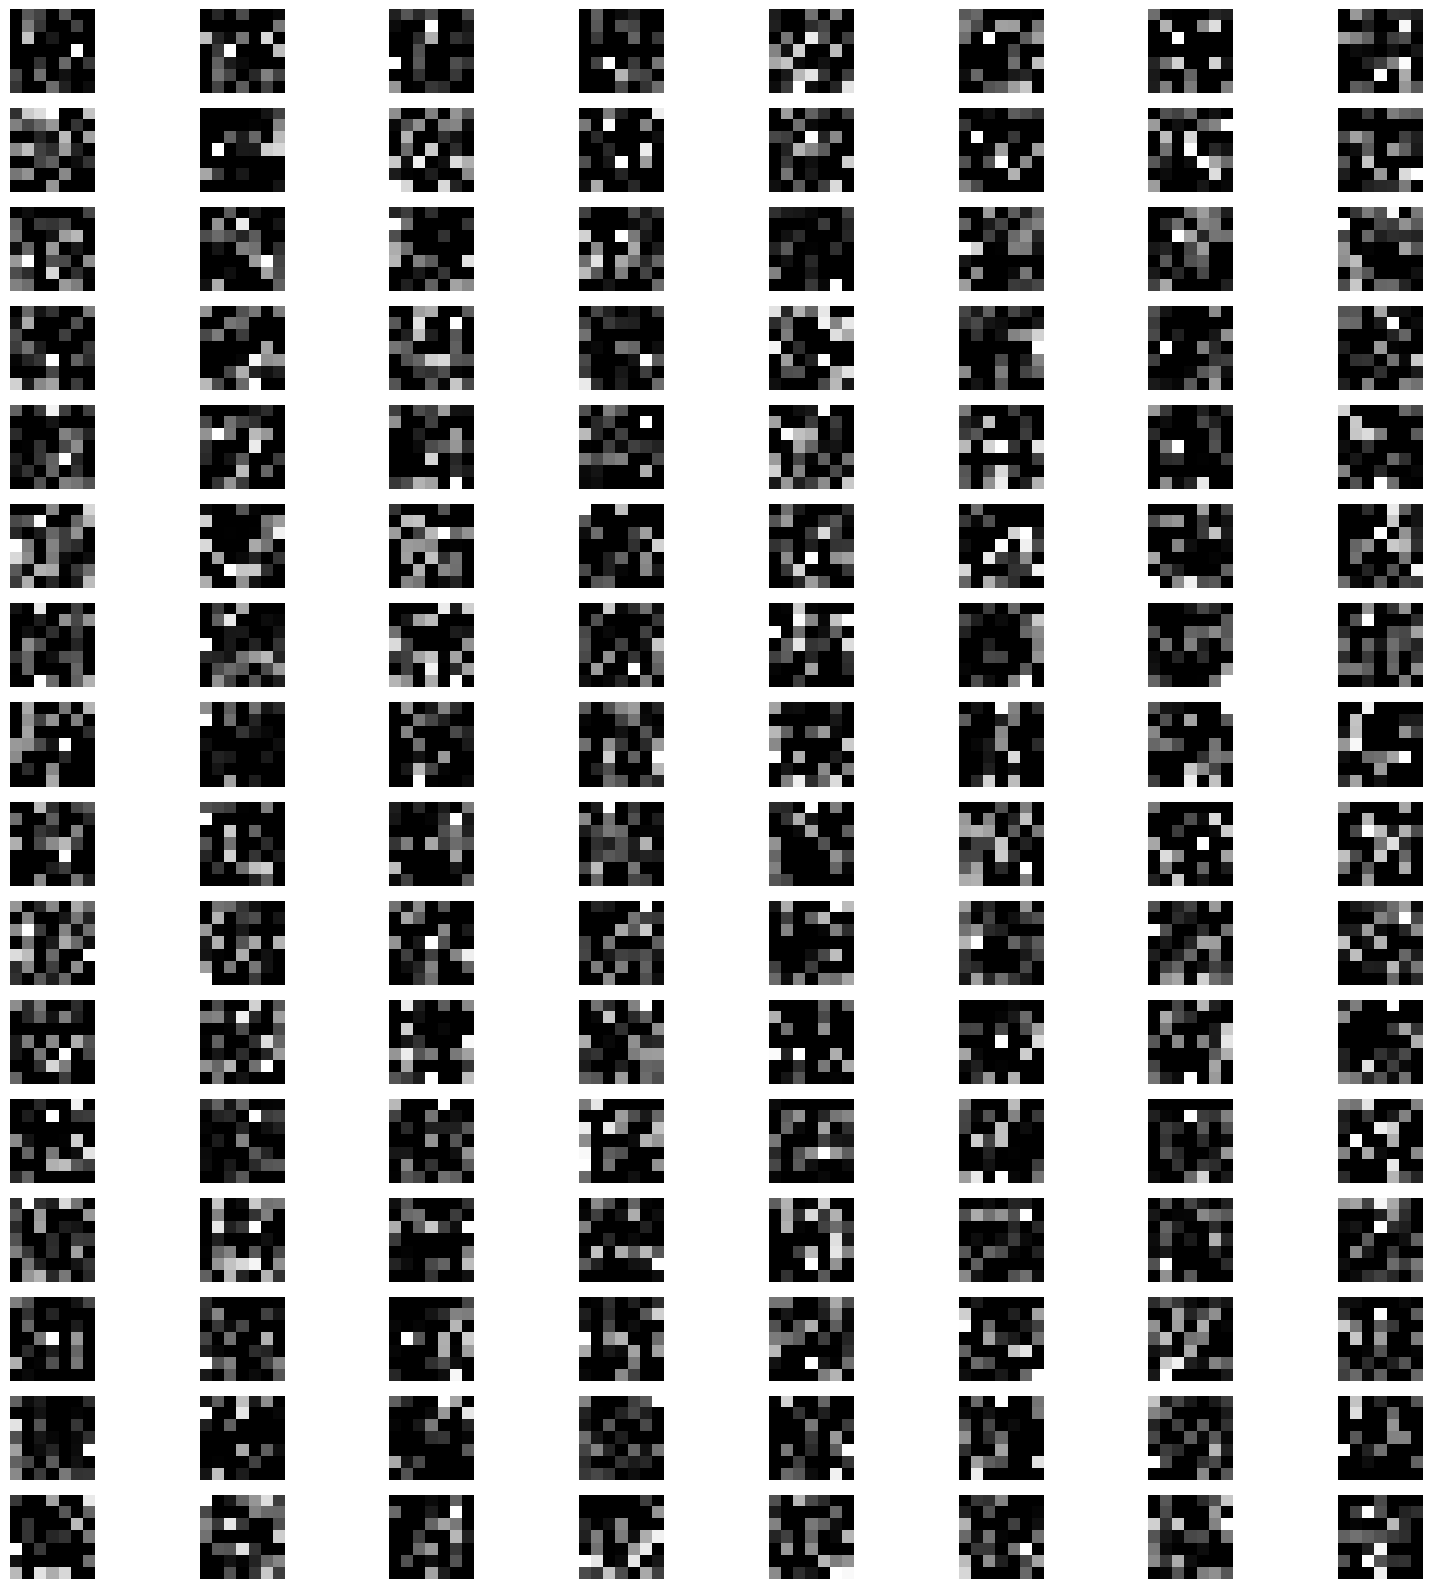

In [55]:
up0_m1 = nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7) # 256, 256, 7, 7
up0_m2 = nn.GroupNorm(8, 2 * n_feat) # 8, 256
up0_m3 = nn.ReLU()

up1 = up0_m1(hiddenvec)
up1 = up0_m2(up1)
up1 = up0_m3(up1)

print("up1.shape:", up1.shape)
print(up1)

channel_visualization("", up1)

##### self.up1 = UnetUp(4 * n_feat = 512, n_feat)

cemb1*up1.shape: torch.Size([1, 256, 7, 7])
cemb1*up1: tensor([[[[ 0.0000,  0.0454,  0.0338,  ...,  0.0434,  0.0000,  0.0000],
          [ 0.0000,  0.0637,  0.0283,  ...,  0.0000,  0.0340,  0.0000],
          [ 0.0000,  0.0980,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0258,  ...,  0.0530,  0.0000,  0.0284],
          [ 0.0364,  0.0000,  0.0577,  ...,  0.0088,  0.0000,  0.0003],
          [ 0.0263,  0.0000,  0.0000,  ...,  0.0163,  0.0000,  0.0065]],

         [[-0.0000, -0.0034, -0.0000,  ..., -0.0000, -0.0000, -0.0007],
          [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0102],
          [-0.0161, -0.0032, -0.0009,  ..., -0.0000, -0.0183, -0.0000],
          ...,
          [-0.0000, -0.0083, -0.0023,  ..., -0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0098, -0.0059,  ..., -0.0035, -0.0110, -0.0056],
          [-0.0000, -0.0058, -0.0000,  ..., -0.0000, -0.0055, -0.0000]],

         [[ 0.0027,  0.0072,  0.0035,  ...,  0.

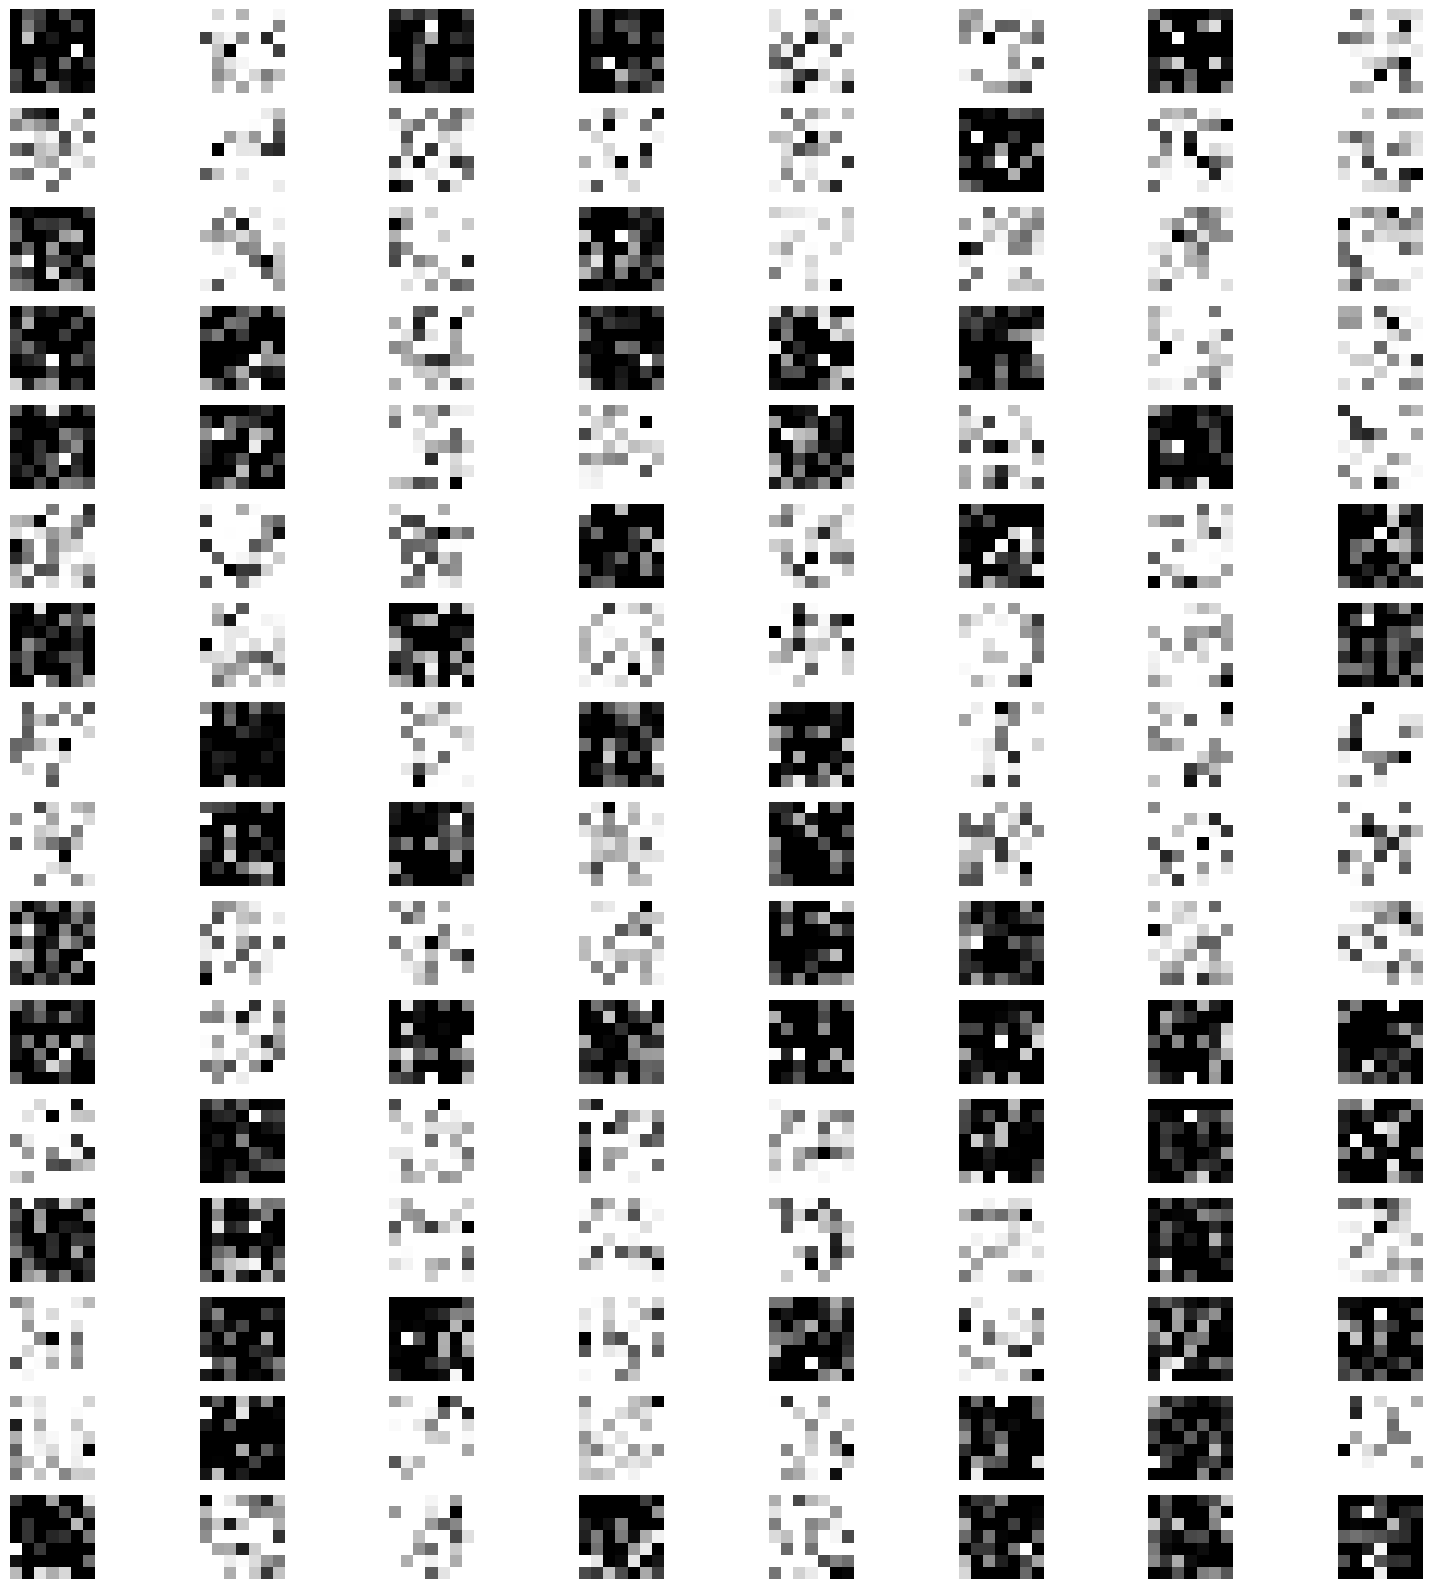

torch.cat((up1_x, skip), 1).shape: torch.Size([1, 512, 7, 7])


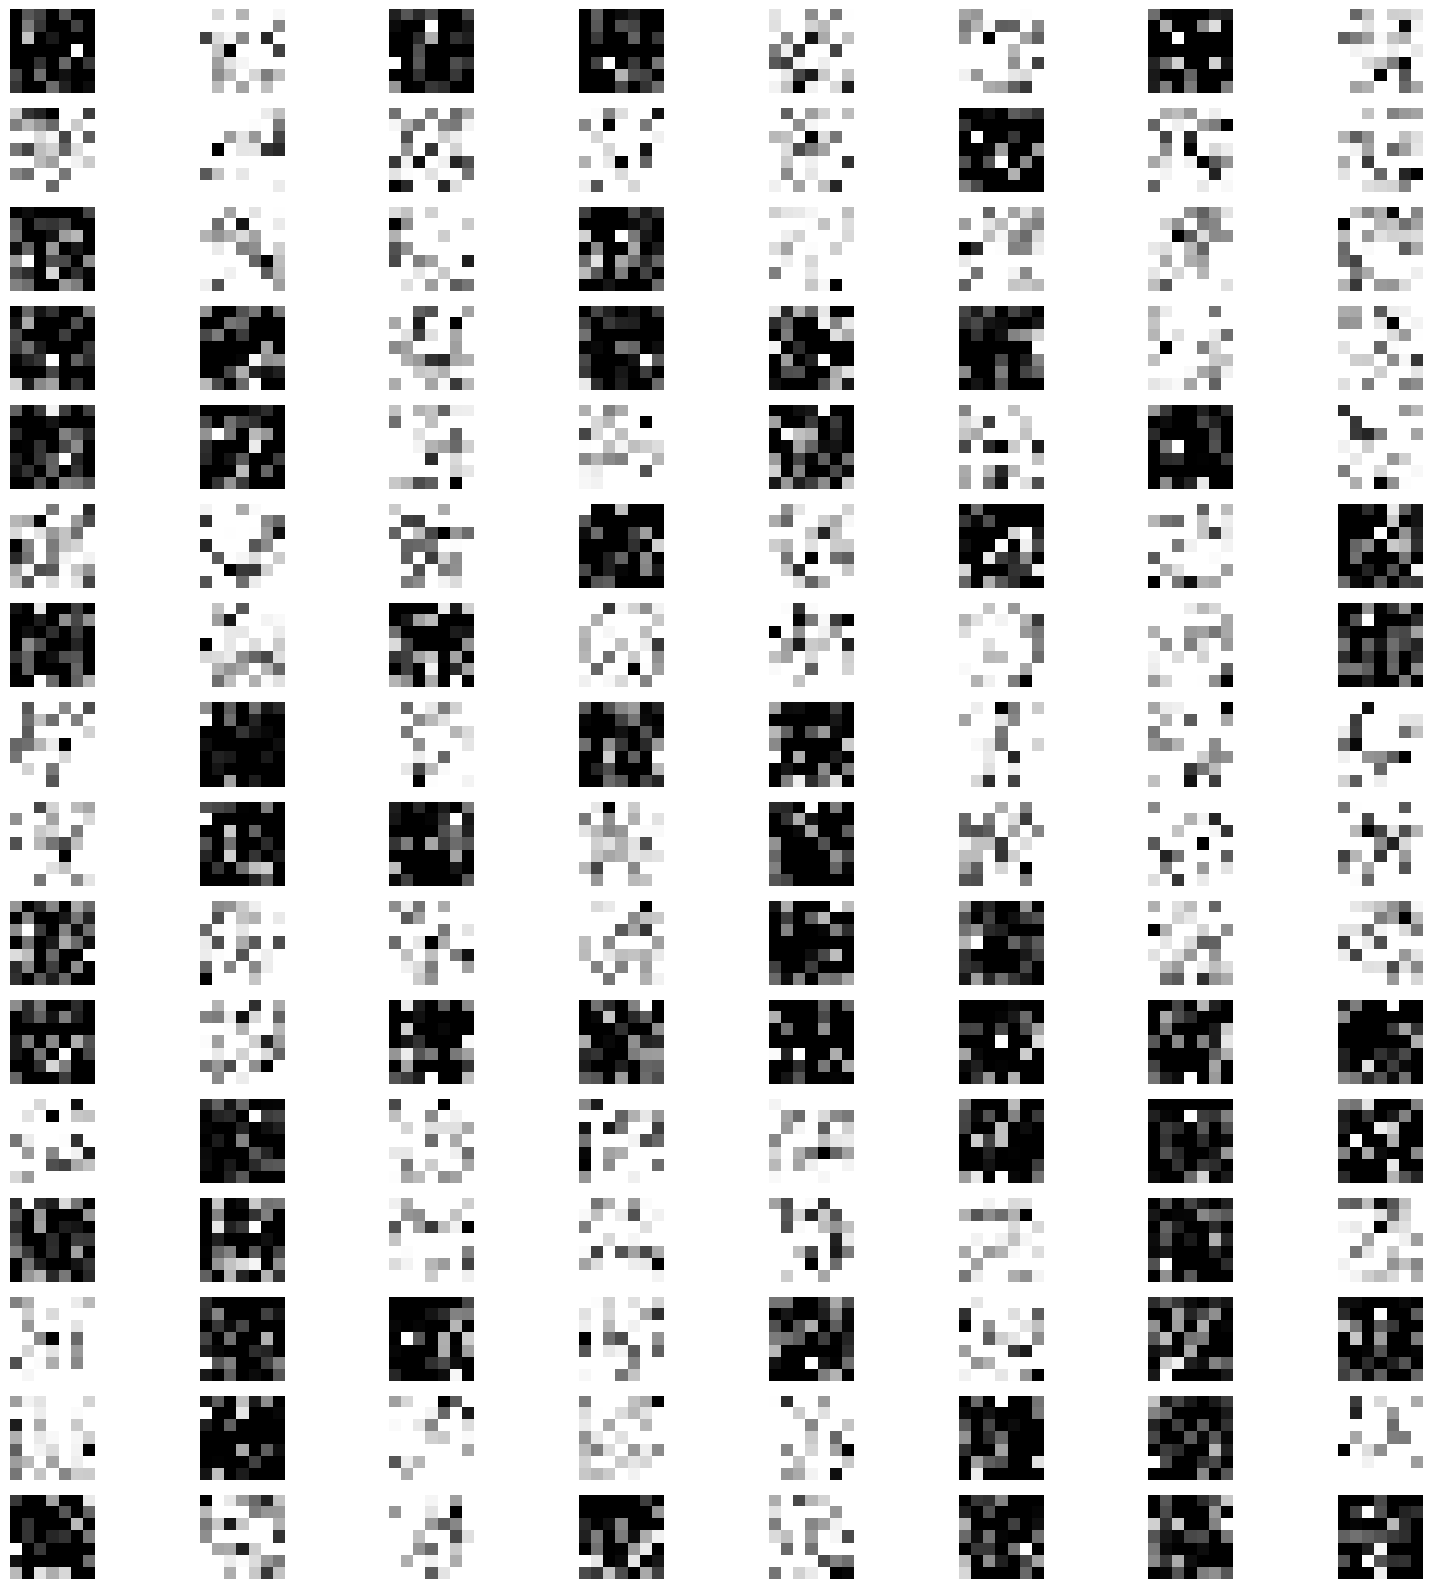

up2 passed layer: tensor([[[[-0.2580, -0.2126, -0.2242,  ..., -0.2146, -0.2580, -0.2580],
          [-0.2580, -0.1942, -0.2297,  ..., -0.2580, -0.2239, -0.2580],
          [-0.2580, -0.1600, -0.2580,  ..., -0.2580, -0.2580, -0.2580],
          ...,
          [-0.2580, -0.2580, -0.2322,  ..., -0.2050, -0.2580, -0.2296],
          [-0.2216, -0.2580, -0.2003,  ..., -0.2492, -0.2580, -0.2577],
          [-0.2317, -0.2580, -0.2580,  ..., -0.2417, -0.2580, -0.2515]],

         [[-0.2569, -0.2603, -0.2569,  ..., -0.2569, -0.2569, -0.2577],
          [-0.2569, -0.2569, -0.2569,  ..., -0.2569, -0.2569, -0.2671],
          [-0.2731, -0.2601, -0.2578,  ..., -0.2569, -0.2752, -0.2569],
          ...,
          [-0.2569, -0.2652, -0.2592,  ..., -0.2569, -0.2569, -0.2569],
          [-0.2569, -0.2668, -0.2629,  ..., -0.2605, -0.2679, -0.2625],
          [-0.2569, -0.2627, -0.2569,  ..., -0.2569, -0.2624, -0.2569]],

         [[ 0.3594,  0.3640,  0.3602,  ...,  0.3567,  0.3567,  0.3629],
          [ 

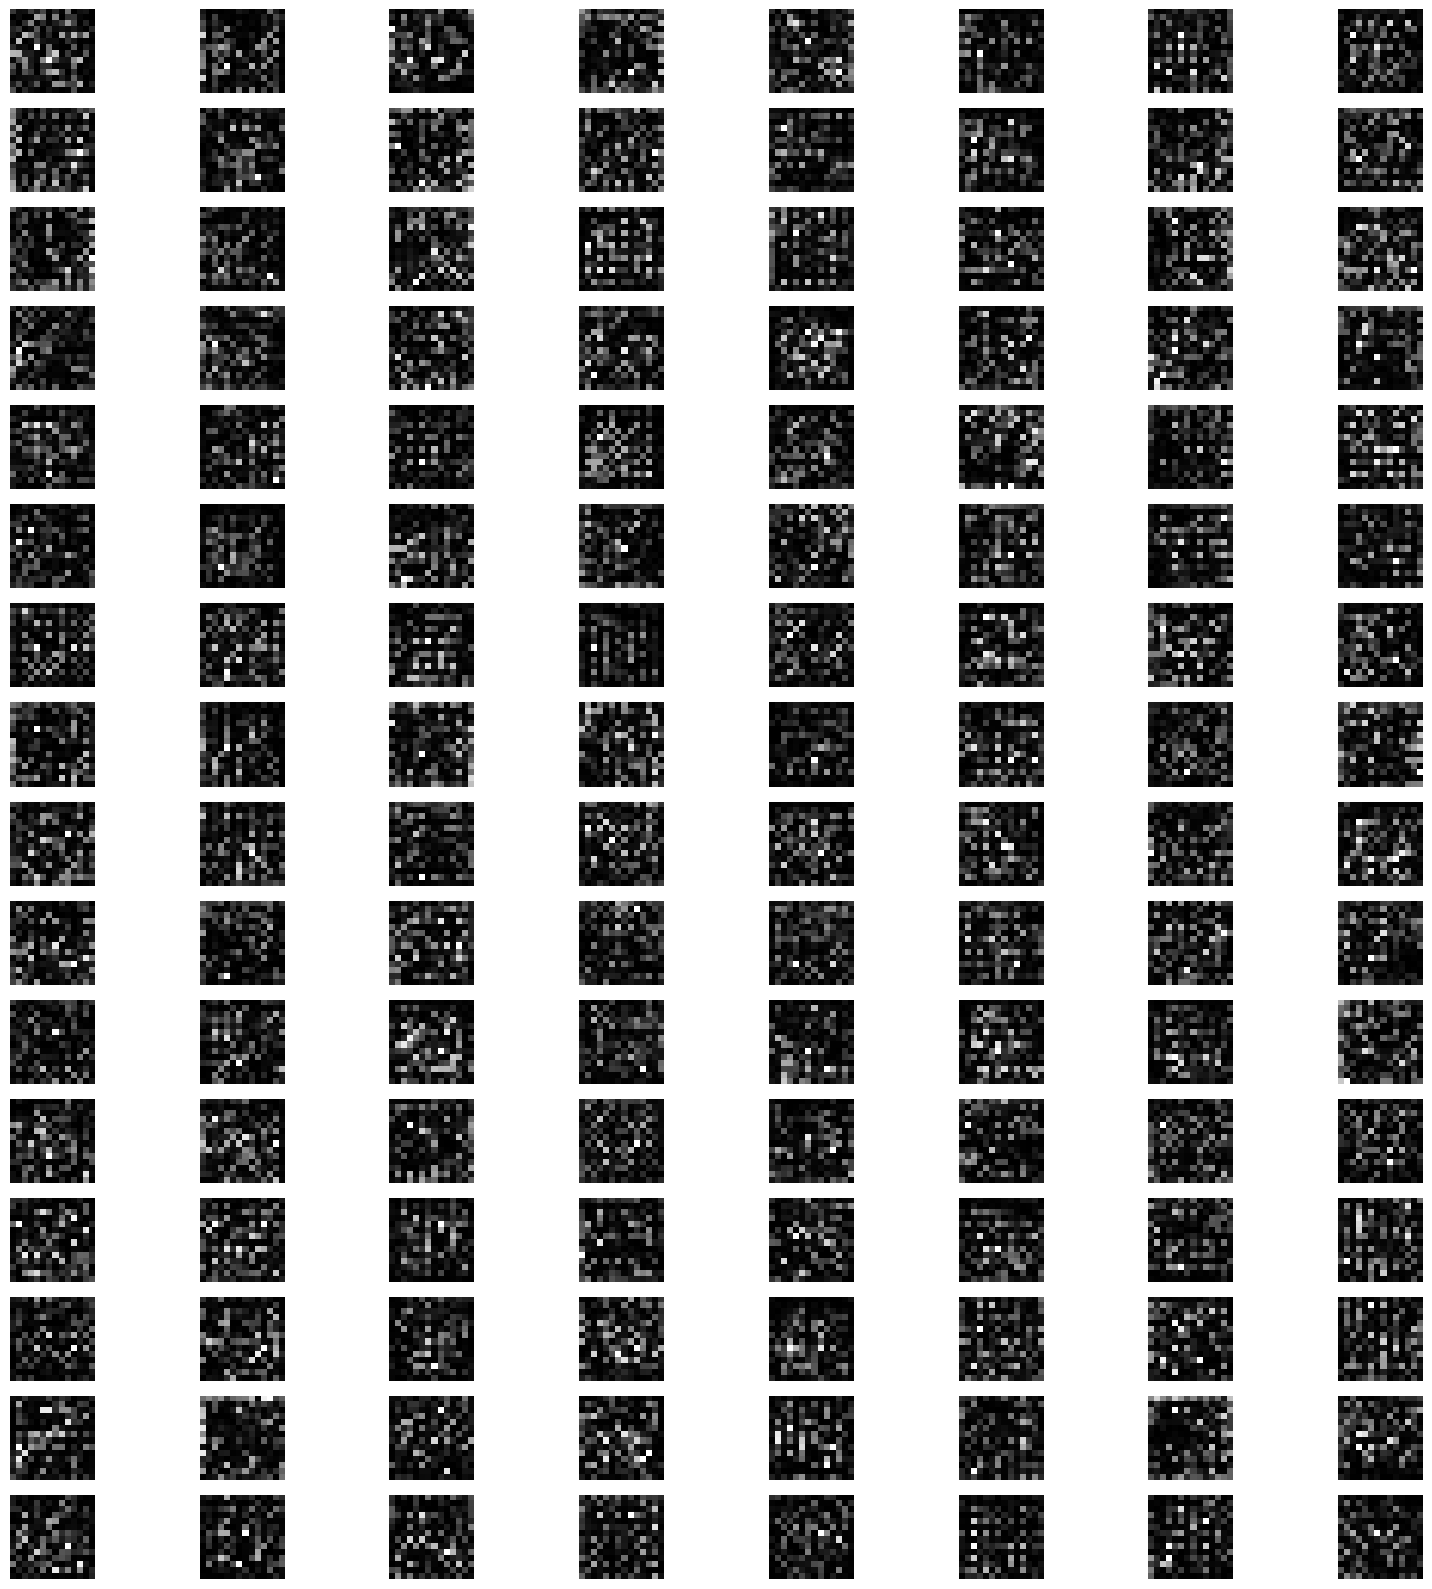

In [56]:
in_channels, out_channels = 4 * n_feat, n_feat
up1_x = cemb1*up1 + temb1
skip = down2
print("cemb1*up1.shape:", (cemb1*up1).shape)
print("cemb1*up1:",cemb1*up1)
print("cemb1*up1 + temb1:",up1_x)
print("up1_x (=cemb1*up1 + temb1):",up1_x.shape)
channel_visualization("", up1_x)

up1_m1 = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
up1_m2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
up1_m3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

print("torch.cat((up1_x, skip), 1).shape:", torch.cat((up1_x, skip), 1).shape)
up2 = torch.cat((up1_x, skip), 1)
channel_visualization("", up2)
print("up2 passed layer:", up2)
up2 = up1_m3(up1_m2(up1_m1(up2)))
print("up2.shape:", up2.shape)
channel_visualization("", up2)


##### self.up2 = UnetUp(2 * n_feat, n_feat)

cemb2*up2.shape: torch.Size([1, 128, 14, 14])
cemb2*up2: tensor([[[[-1.1955e-02,  9.9435e-04,  9.3368e-05,  ...,  8.7491e-05,
           -1.7495e-03,  5.1070e-03],
          [ 4.8547e-03,  1.0108e-03,  4.8220e-03,  ...,  2.8559e-03,
            4.5483e-03,  4.9311e-03],
          [ 9.9931e-04,  4.9621e-03, -9.4898e-03,  ...,  4.7201e-03,
           -5.7345e-03,  5.1216e-03],
          ...,
          [ 3.6940e-03,  2.2814e-03,  1.4000e-03,  ..., -9.0833e-04,
            5.1207e-03,  2.9683e-03],
          [-3.8188e-03, -1.8681e-02,  3.6453e-03,  ..., -4.9409e-02,
            4.7176e-03, -5.7186e-03],
          [-1.9247e-02,  4.7601e-03, -7.7432e-03,  ...,  4.2652e-03,
            2.9264e-03,  3.0011e-03]],

         [[ 4.5565e-03, -8.9835e-03, -6.6488e-03,  ...,  6.3675e-02,
            8.8090e-03, -5.9376e-03],
          [ 1.3993e-02, -8.6796e-03,  3.2613e-02,  ..., -5.4658e-03,
            3.9194e-02,  1.6295e-02],
          [ 4.1720e-02, -2.2387e-03,  2.1699e-02,  ..., -4.0007e-03,
 

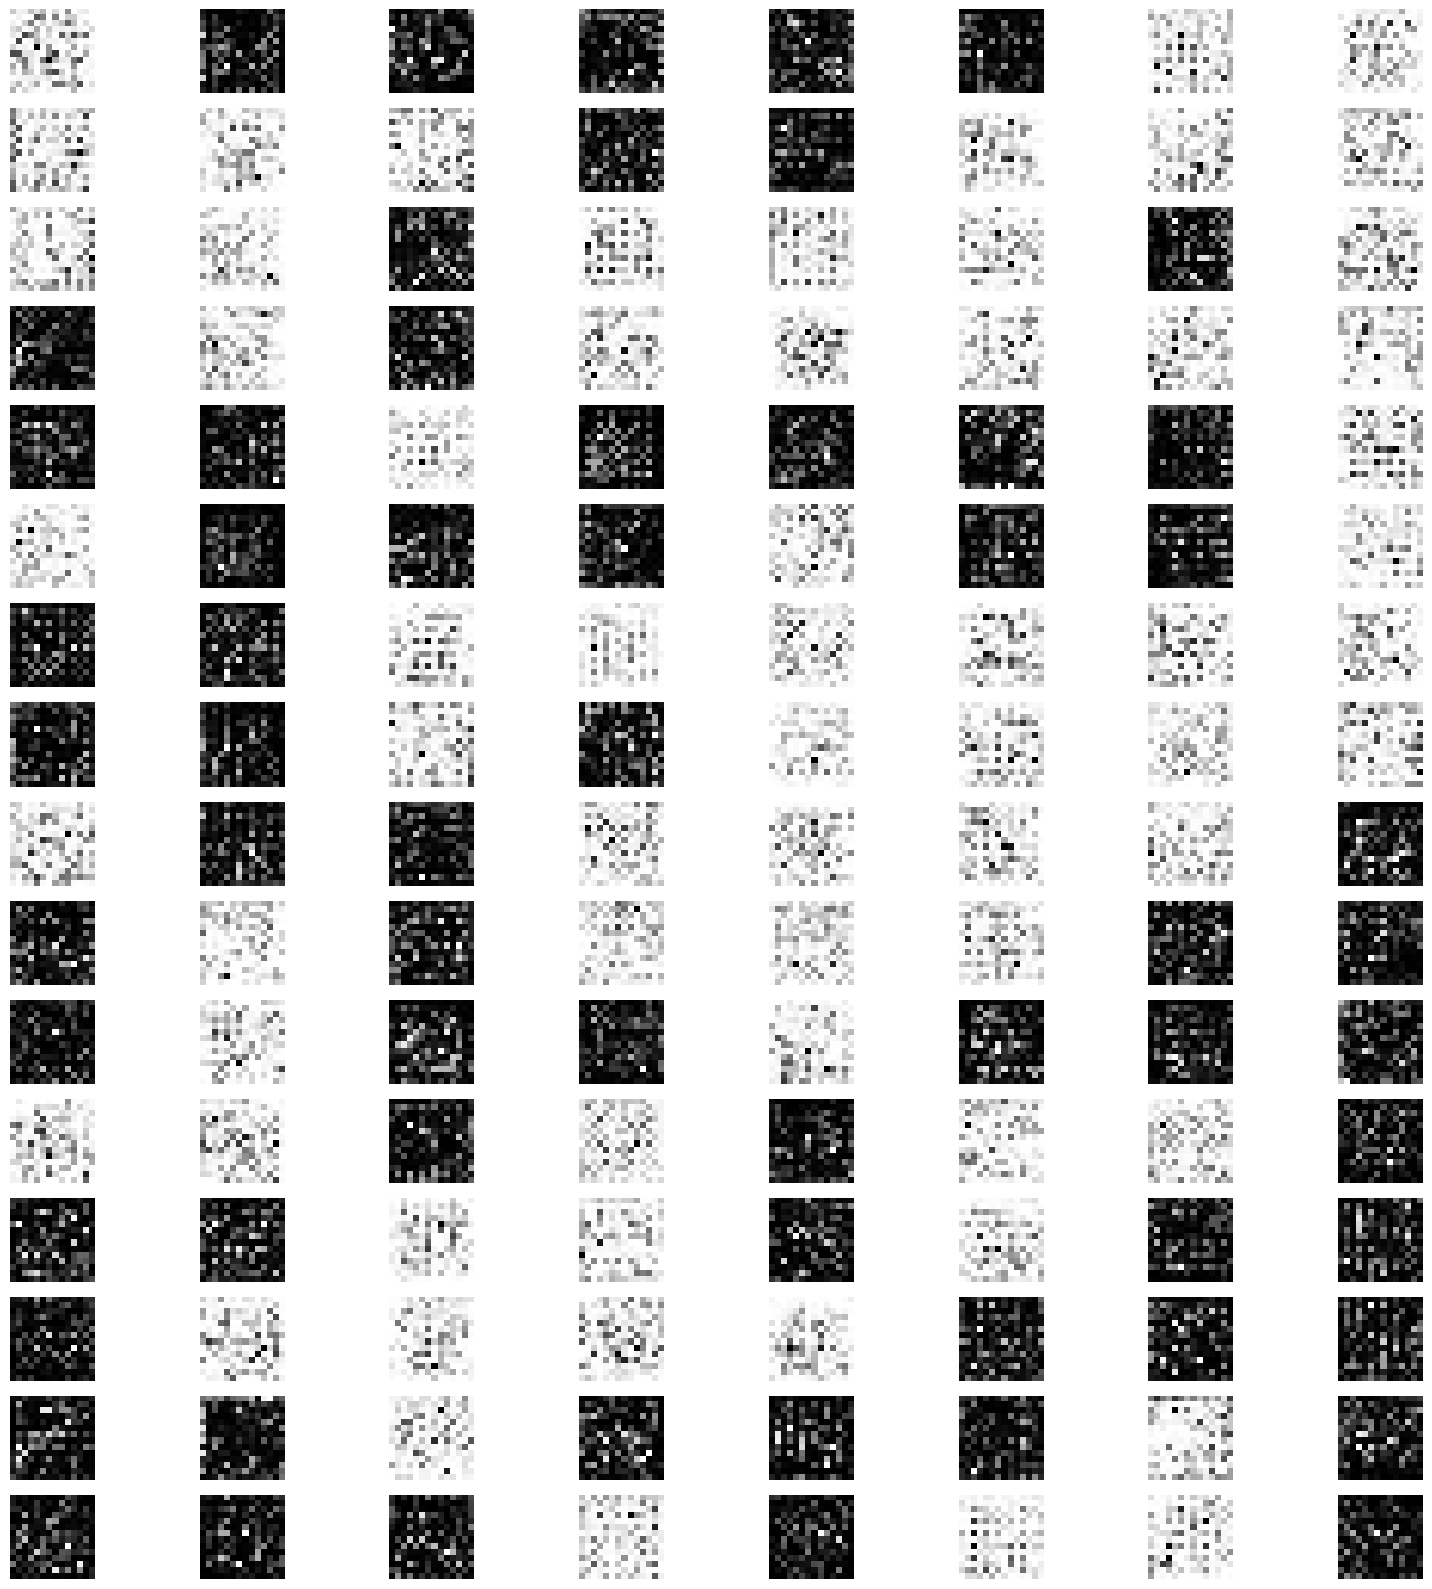

torch.cat((up2_x, skip), 1).shape: torch.Size([1, 256, 14, 14])


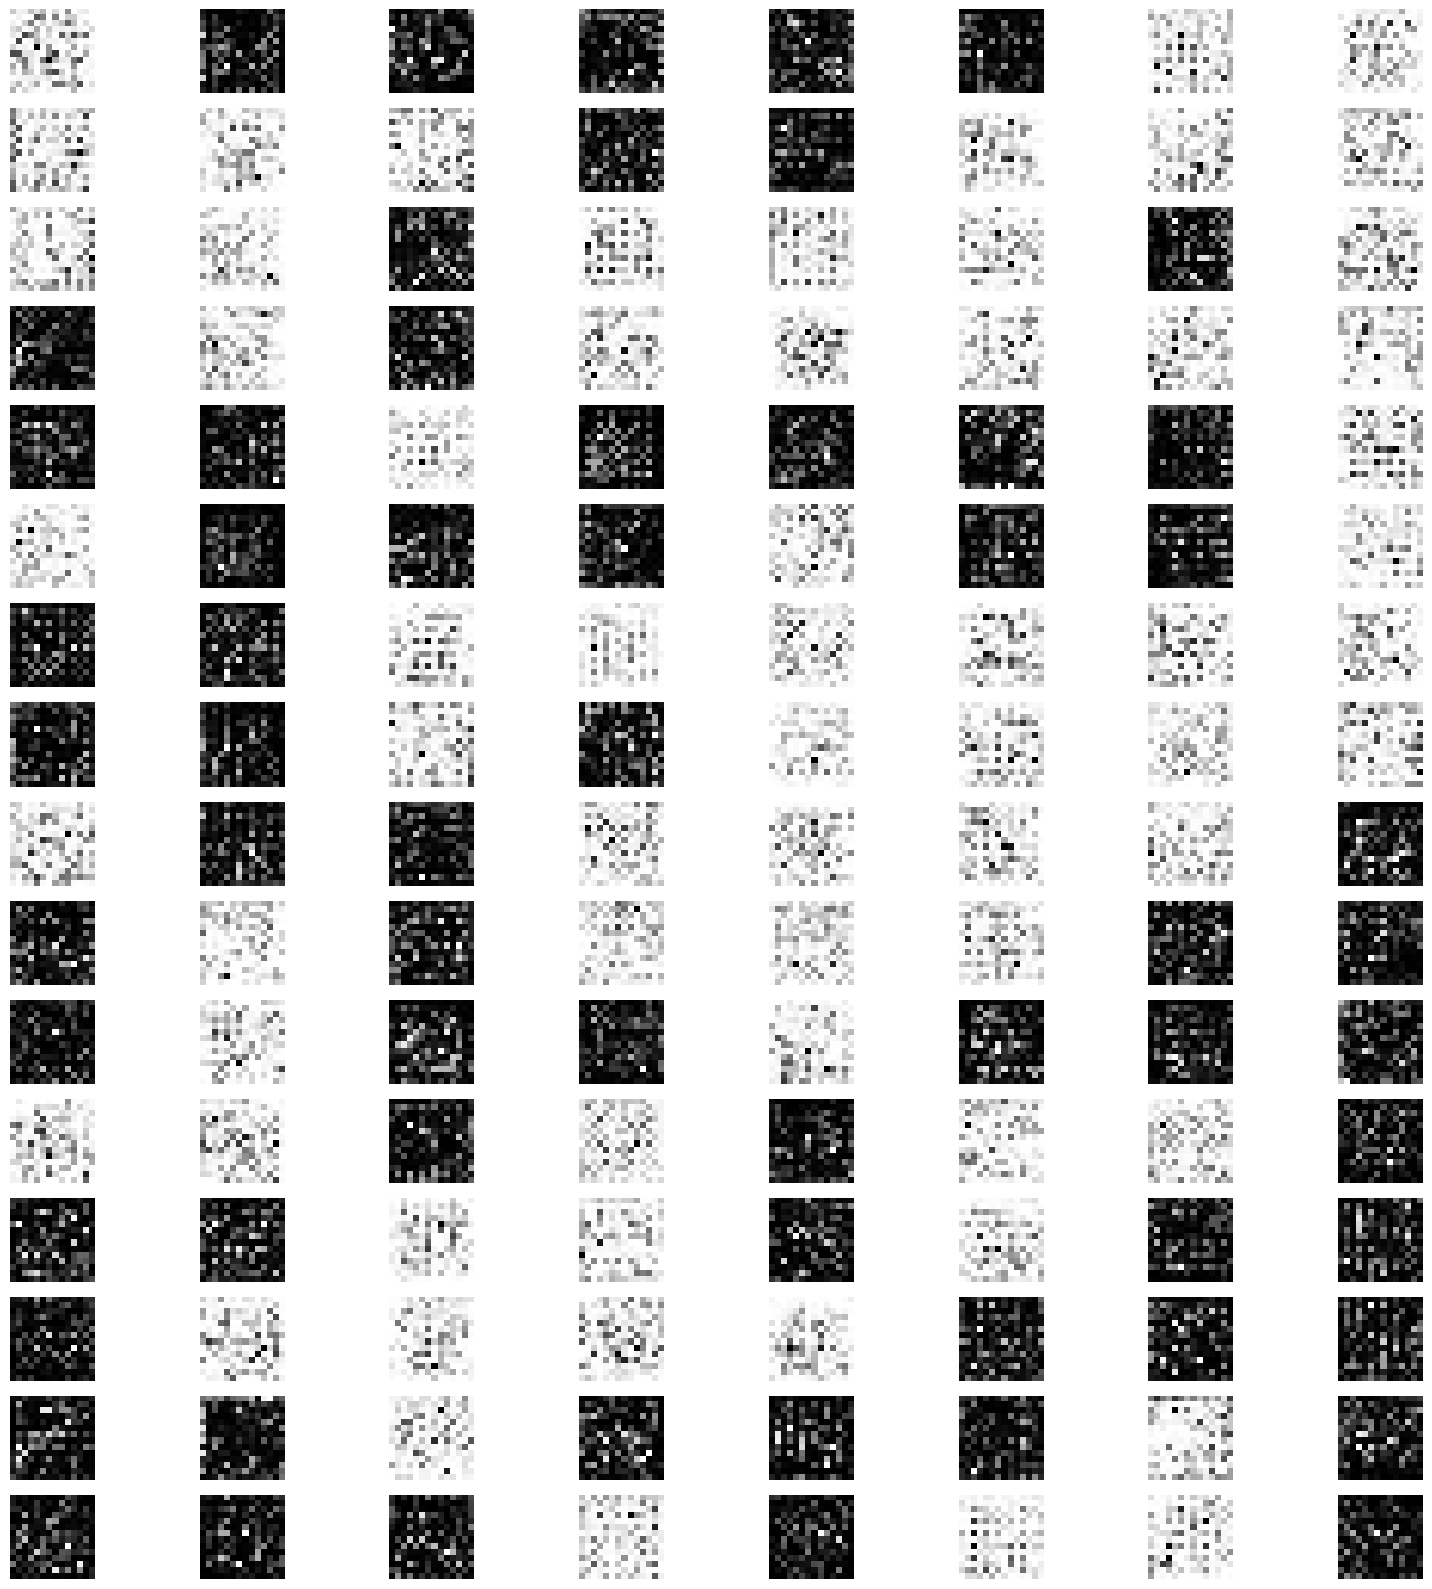

up3 passed layer: tensor([[[[-0.2640, -0.2510, -0.2519,  ..., -0.2519, -0.2538, -0.2469],
          [-0.2471, -0.2510, -0.2472,  ..., -0.2491, -0.2475, -0.2471],
          [-0.2510, -0.2470, -0.2615,  ..., -0.2473, -0.2577, -0.2469],
          ...,
          [-0.2483, -0.2497, -0.2506,  ..., -0.2529, -0.2469, -0.2490],
          [-0.2558, -0.2707, -0.2484,  ..., -0.3014, -0.2473, -0.2577],
          [-0.2713, -0.2472, -0.2597,  ..., -0.2477, -0.2491, -0.2490]],

         [[-0.1974, -0.2109, -0.2086,  ..., -0.1382, -0.1931, -0.2079],
          [-0.1879, -0.2106, -0.1693,  ..., -0.2074, -0.1627, -0.1856],
          [-0.1602, -0.2042, -0.1802,  ..., -0.2059, -0.1815, -0.2029],
          ...,
          [-0.0698, -0.2100, -0.1715,  ..., -0.2111, -0.1848, -0.2083],
          [-0.2006, -0.2105, -0.1691,  ..., -0.1627, -0.1780, -0.2110],
          [-0.1890, -0.2058, -0.1857,  ..., -0.2111, -0.1602, -0.2111]],

         [[-0.3250, -0.3412, -0.3382,  ..., -0.2955, -0.3338, -0.1586],
          [-

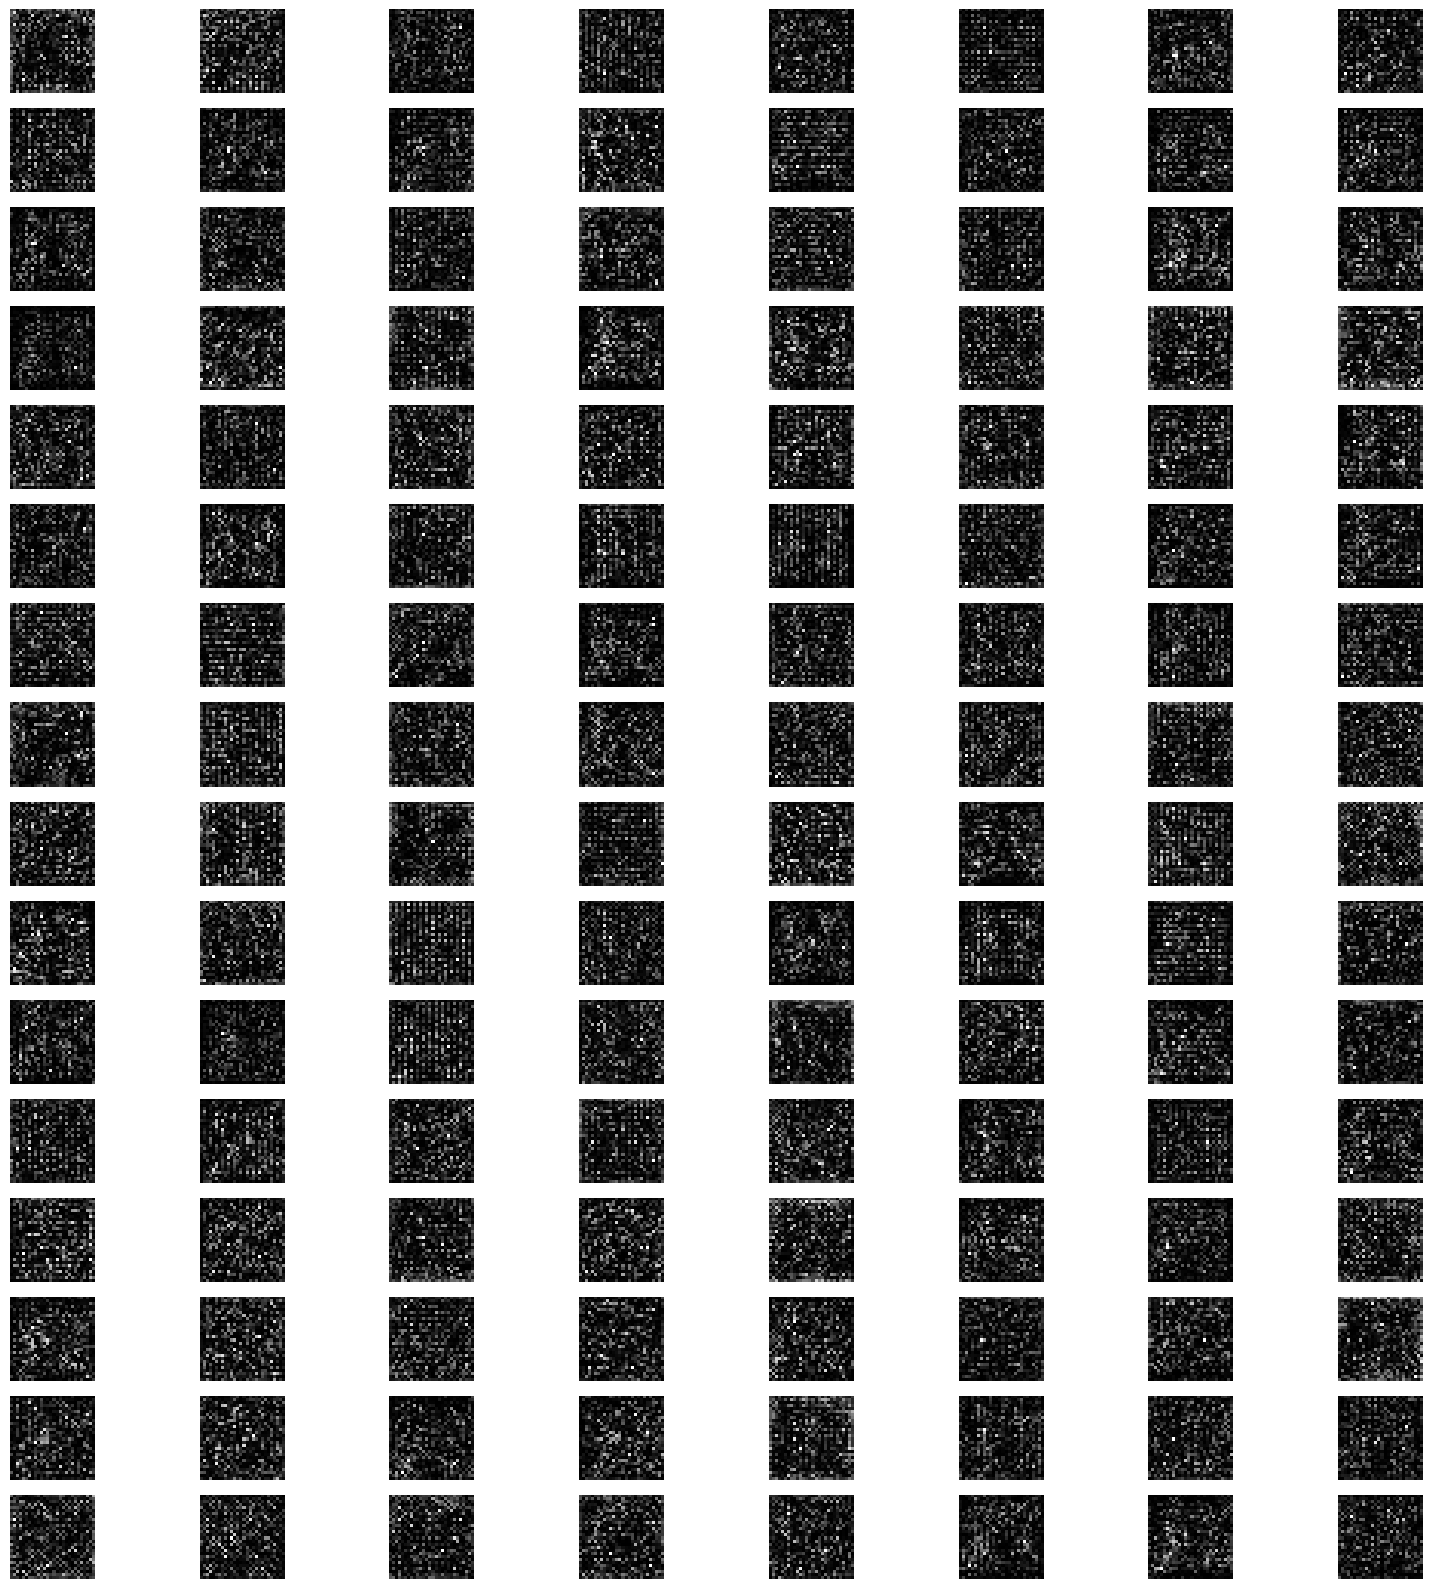

In [57]:
in_channels, out_channels = 2 * n_feat, n_feat
up2_x = cemb2*up2 + temb2
skip = down1
print("cemb2*up2.shape:", (cemb2*up2).shape)
print("cemb2*up2:",cemb2*up2)
print("cemb2*up2 + temb2:",up2_x)
print("up2_x (=cemb2*up2 + temb2):",up2_x.shape)
channel_visualization("", up2_x)

up2_m1 = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
up2_m2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
up2_m3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

print("torch.cat((up2_x, skip), 1).shape:", torch.cat((up2_x, skip), 1).shape)
up3 = torch.cat((up2_x, skip), 1)
channel_visualization("", up3)
print("up3 passed layer:", up3)
up3 = up2_m3(up2_m2(up2_m1(up3)))
channel_visualization("", up3)


##### self.out = nn.Sequential(
     nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
     nn.GroupNorm(8, n_feat),
     nn.ReLU(),
     nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
 )

up3_cat_x.shape: torch.Size([1, 256, 28, 28])


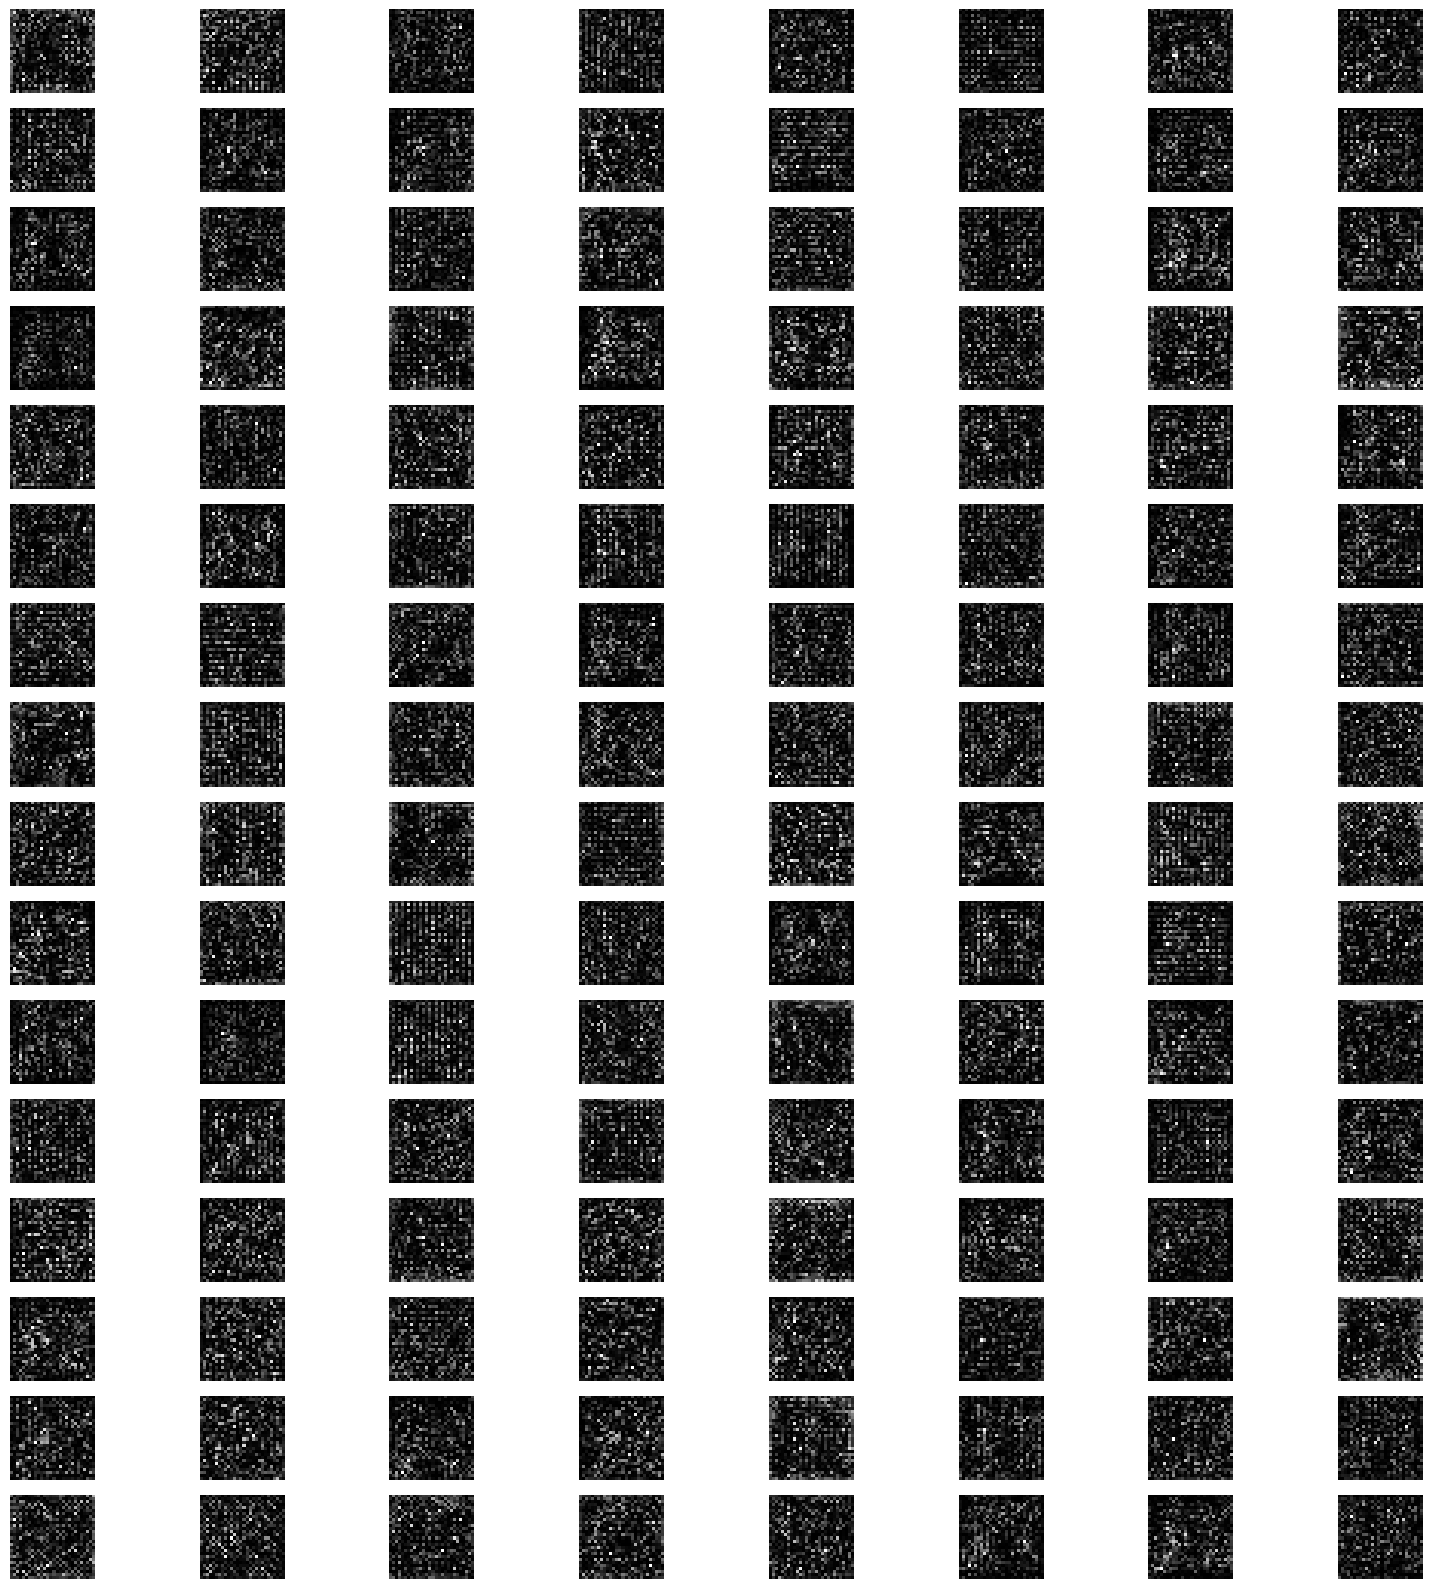

out Conv2d(256 -> 128): tensor([[[[-0.2629, -0.3833, -0.1403,  ..., -0.2389, -0.7113, -0.3527],
          [-0.0754, -0.2572,  0.3451,  ...,  0.4290,  0.4292, -0.0422],
          [-0.1114, -0.3801, -0.2145,  ..., -0.3946,  0.5589,  0.3374],
          ...,
          [-0.2271,  0.0658,  0.5008,  ..., -0.5245, -0.4071, -0.1807],
          [-0.1291, -0.5683, -0.0388,  ..., -0.1652,  0.0036, -0.2865],
          [-0.1778, -0.0896, -0.3253,  ..., -0.0361, -0.4019, -0.1222]],

         [[-0.4042, -0.5678, -0.3930,  ..., -0.5670, -0.7364, -0.1045],
          [-0.1970, -0.3757, -0.2601,  ..., -0.4784, -0.6021, -0.3179],
          [-0.2224, -0.1812, -0.0716,  ..., -0.3930, -0.5165,  0.2288],
          ...,
          [-0.4334, -0.6772, -0.0654,  ...,  0.4865, -0.2395,  0.0980],
          [ 0.0328,  0.0741, -0.1355,  ...,  0.1257,  0.0052, -0.1879],
          [ 0.1448, -0.1987, -0.1612,  ...,  0.0713, -0.0423, -0.1574]],

         [[ 0.1328,  0.3076, -0.0704,  ..., -0.3459,  0.3070, -0.2147],
      

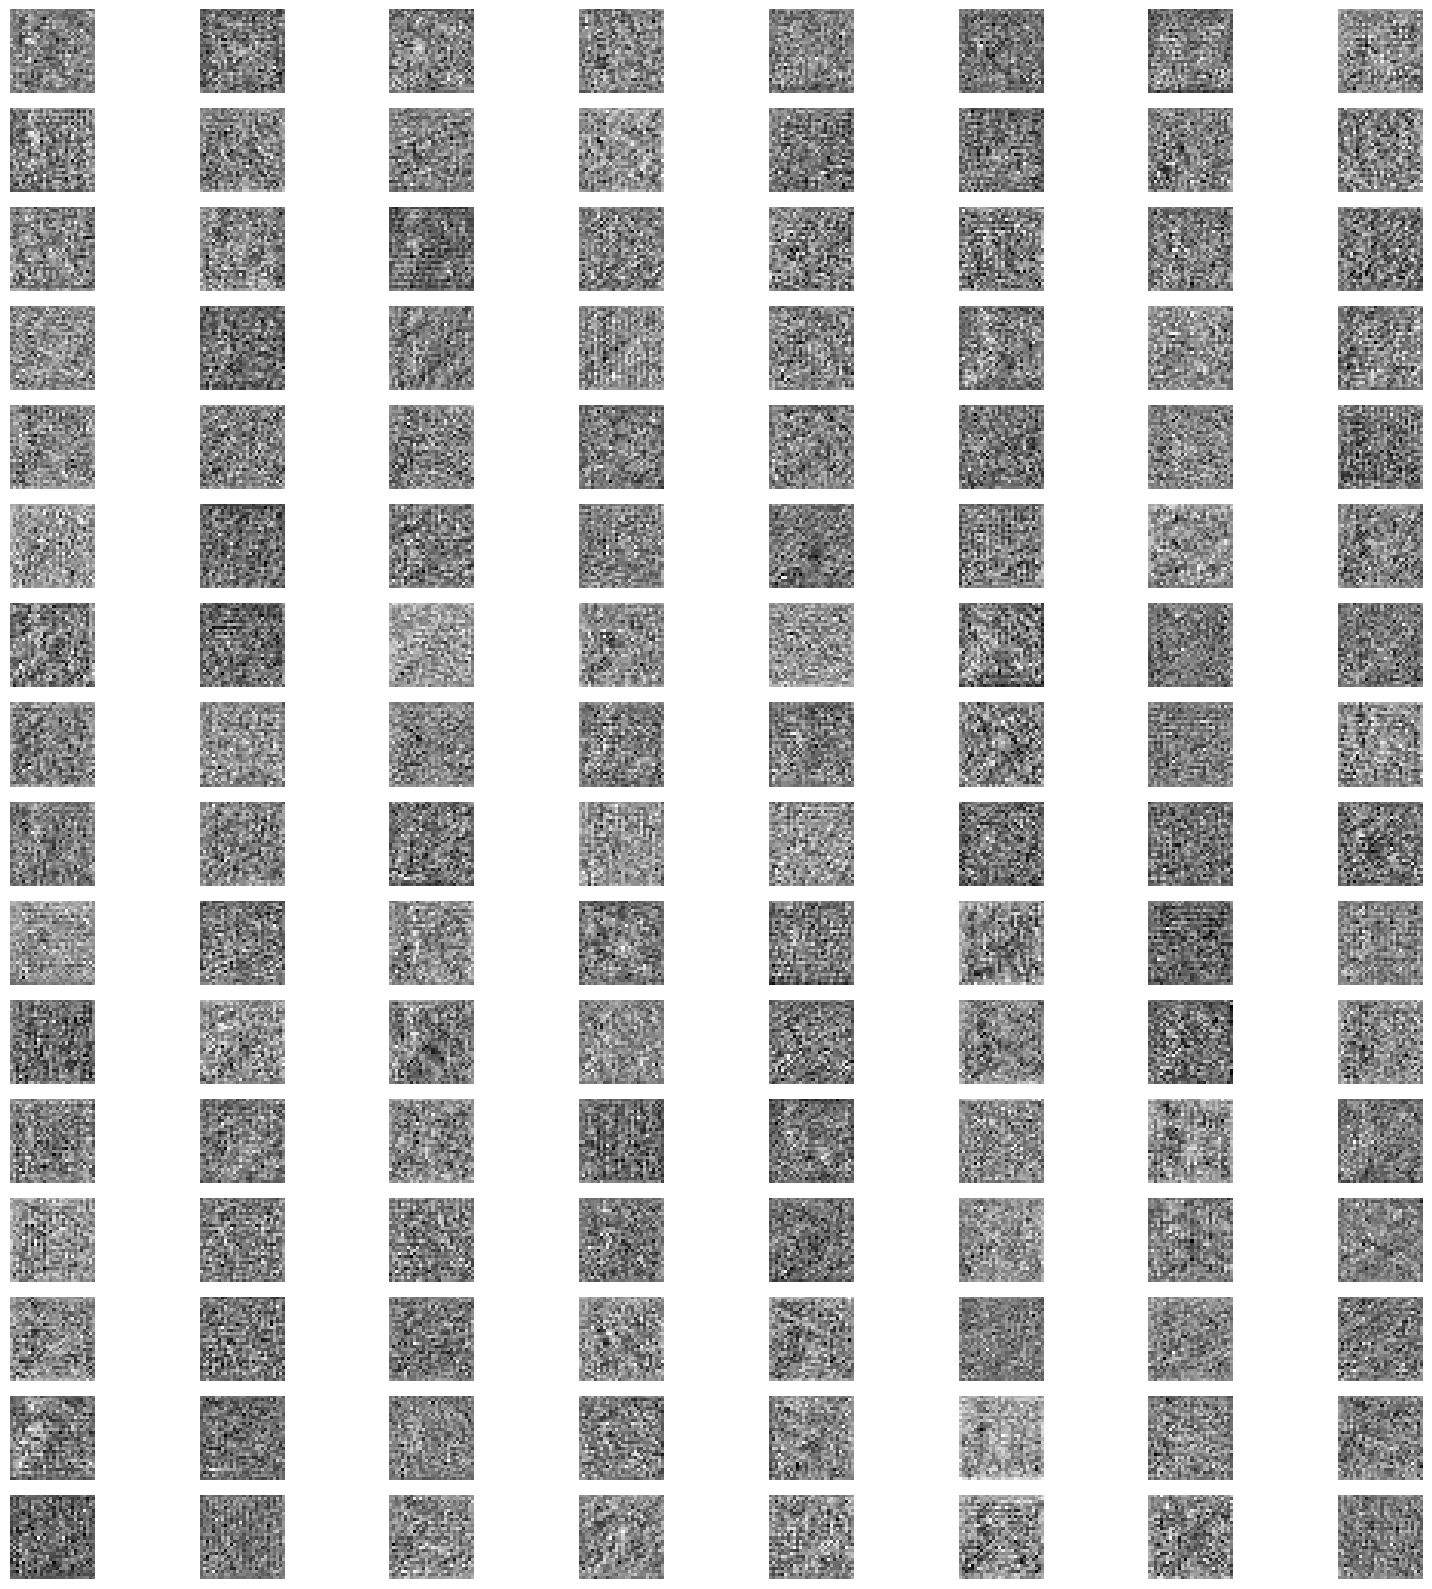

out GroupNorm: tensor([[[[-0.7239, -1.0221, -0.4206,  ..., -0.6646, -1.8345, -0.9465],
          [-0.2598, -0.7099,  0.7816,  ...,  0.9893,  0.9897, -0.1776],
          [-0.3488, -1.0141, -0.6042,  ..., -1.0502,  1.3108,  0.7625],
          ...,
          [-0.6353,  0.0898,  1.1670,  ..., -1.3718, -1.0812, -0.5204],
          [-0.3926, -1.4802, -0.1692,  ..., -0.4822, -0.0640, -0.7824],
          [-0.5133, -0.2948, -0.8785,  ..., -0.1624, -1.0683, -0.3756]],

         [[-1.0739, -1.4789, -1.0462,  ..., -1.4771, -1.8964, -0.3317],
          [-0.5610, -1.0034, -0.7170,  ..., -1.2576, -1.5639, -0.8603],
          [-0.6236, -0.5218, -0.2504,  ..., -1.0461, -1.3521,  0.4934],
          ...,
          [-1.1463, -1.7499, -0.2349,  ...,  1.1316, -0.6661,  0.1697],
          [ 0.0082,  0.1105, -0.4085,  ...,  0.2383, -0.0603, -0.5383],
          [ 0.2856, -0.5651, -0.4722,  ...,  0.1035, -0.1777, -0.4627]],

         [[ 0.2557,  0.6887, -0.2475,  ..., -0.9296,  0.6871, -0.6046],
          [-0.1

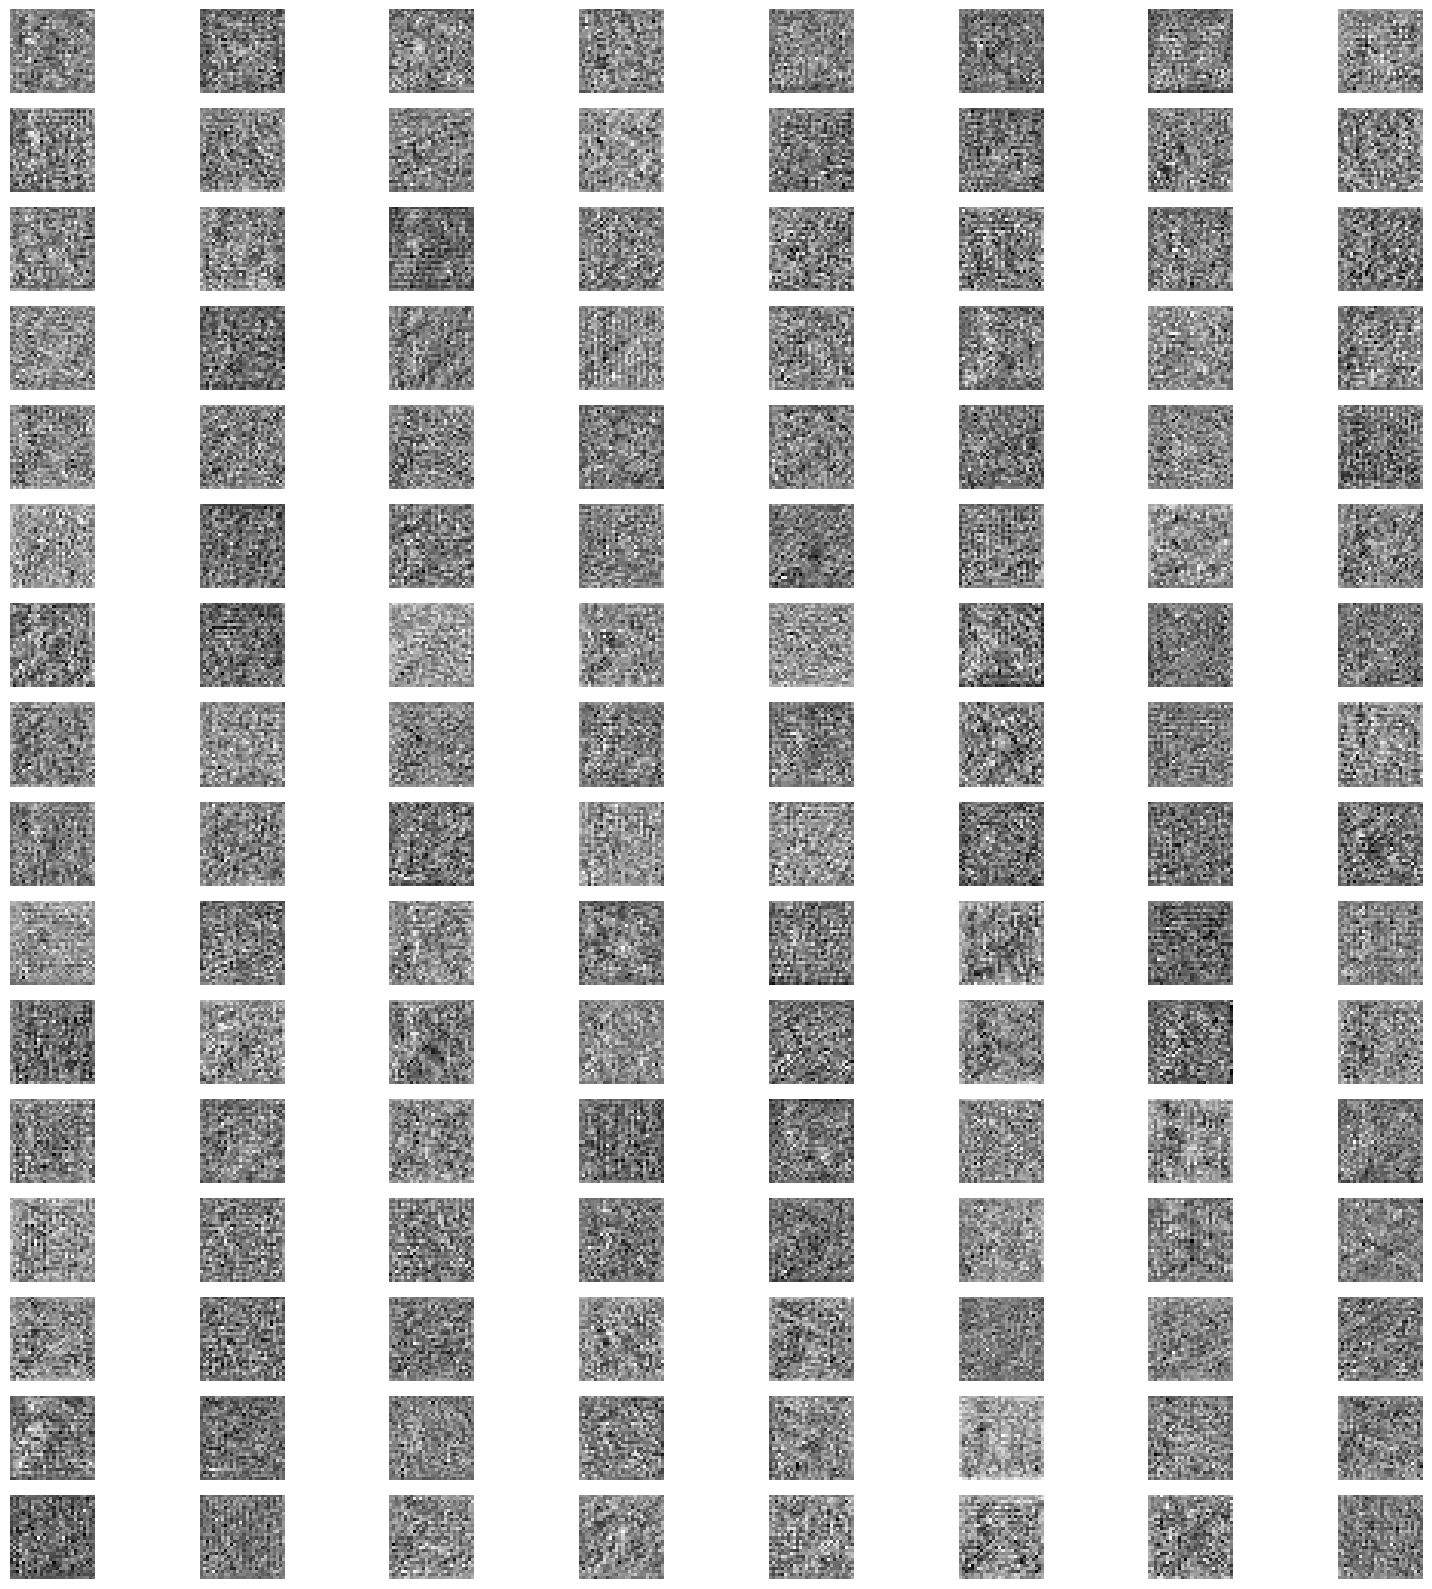

out ReLU: tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.7816,  ..., 0.9893, 0.9897, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.3108, 0.7625],
          ...,
          [0.0000, 0.0898, 1.1670,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4934],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 1.1316, 0.0000, 0.1697],
          [0.0082, 0.1105, 0.0000,  ..., 0.2383, 0.0000, 0.0000],
          [0.2856, 0.0000, 0.0000,  ..., 0.1035, 0.0000, 0.0000]],

         [[0.2557, 0.6887, 0.0000,  ..., 0.0000, 0.6871, 0.0000],
          [0.0000, 0.9566, 0.1137,  ..., 0.0000, 1.5766, 0.5806],
          [1.0707, 0.0000, 0.000

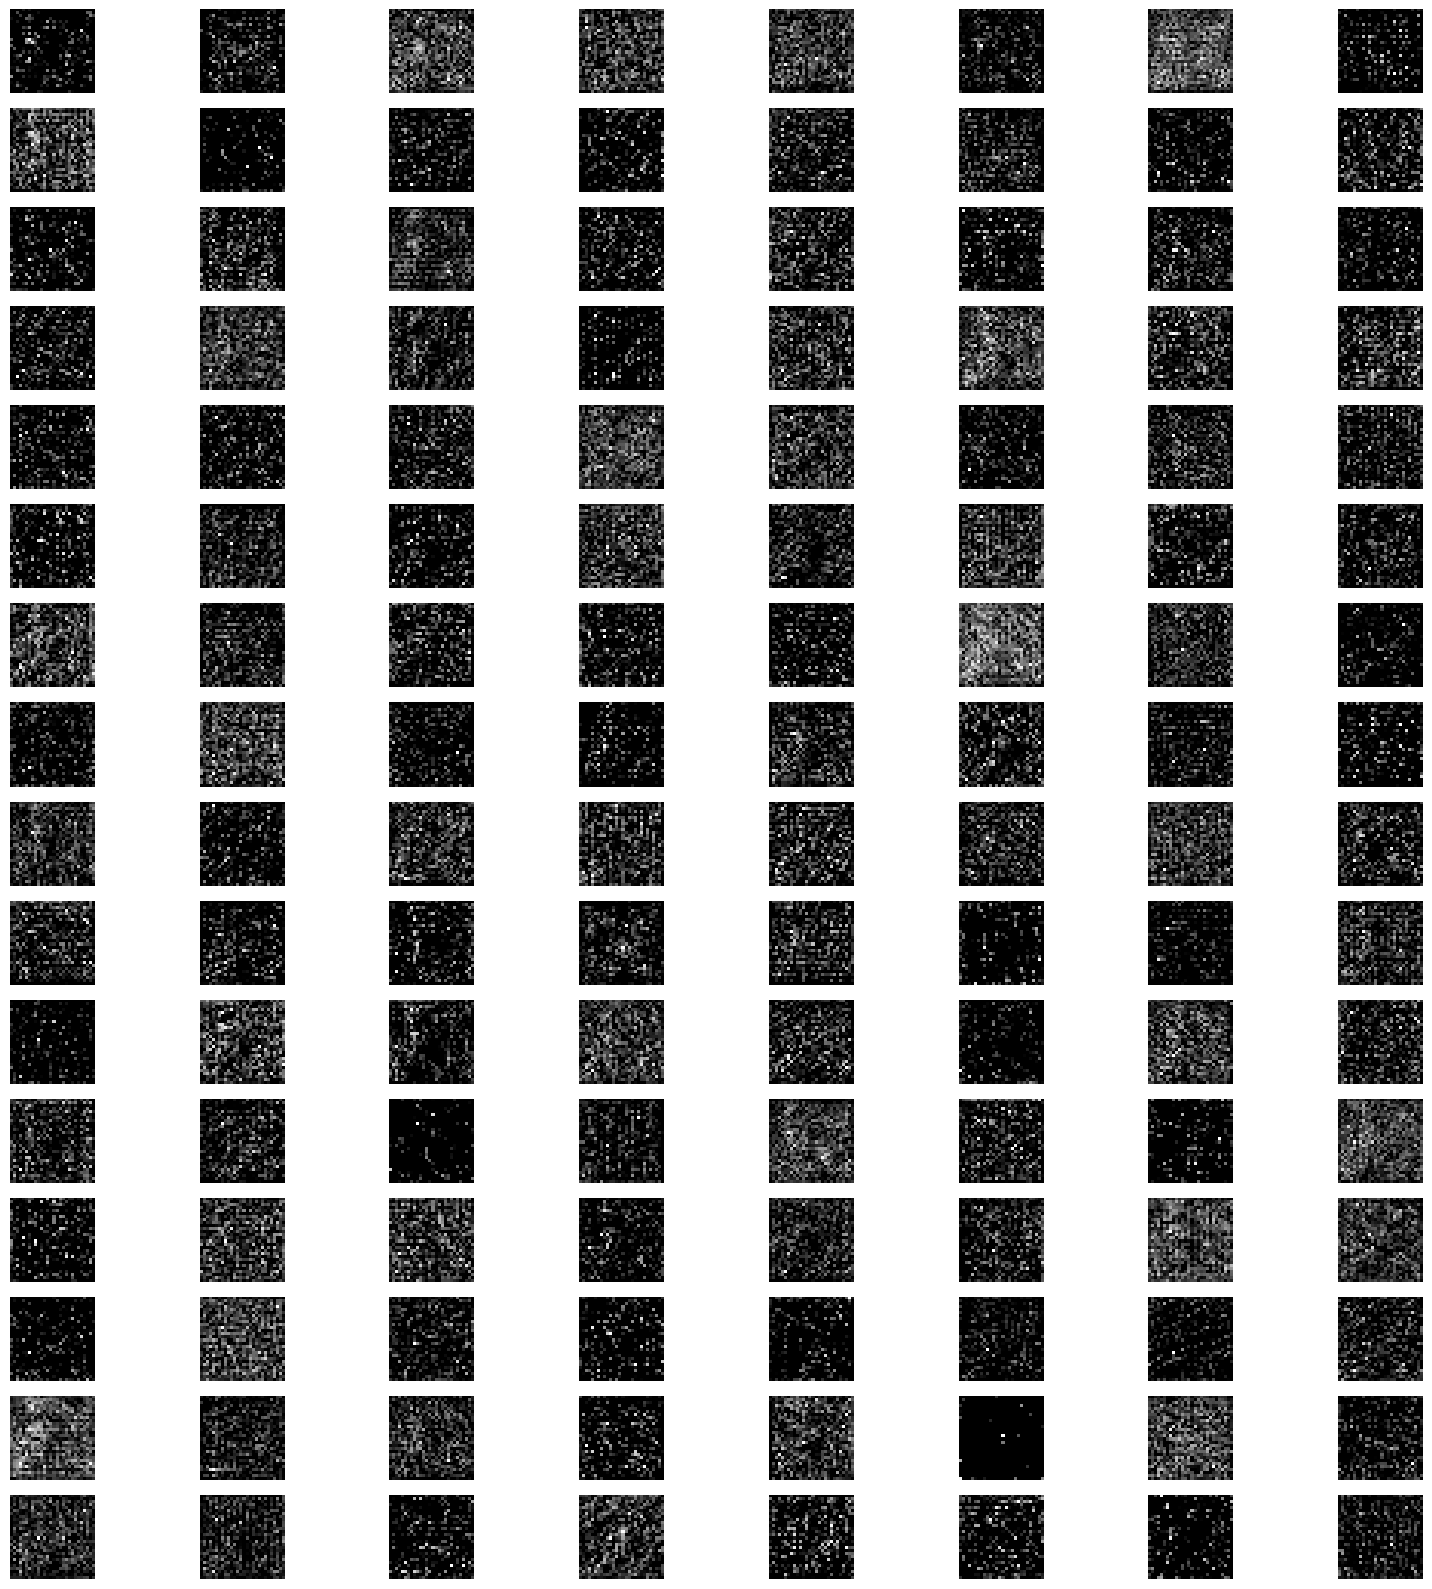

out Conv2d(128 -> 1): tensor([[[[ 2.5313e-03, -4.9145e-02,  3.3488e-02, -1.0838e-01, -1.9026e-01,
           -7.7851e-02, -3.6375e-01, -1.3247e-02, -1.6899e-01,  2.5488e-01,
           -6.3369e-02, -1.3560e-01, -3.9869e-01, -1.3531e-01, -2.1630e-01,
           -1.9523e-01,  1.2324e-01,  8.4176e-02,  1.0380e-02, -6.6119e-02,
           -1.1675e-01, -1.1426e-02, -1.4394e-01, -5.1121e-02, -3.5154e-02,
           -4.2012e-02, -2.3377e-01, -1.4680e-01],
          [ 9.7370e-02, -2.6272e-01,  1.8929e-01, -1.6810e-01, -1.1527e-01,
            7.9021e-02, -1.5188e-01,  3.4465e-01, -7.3803e-02,  4.4847e-02,
           -8.3963e-02,  2.3287e-01, -3.3697e-01,  9.1147e-02,  2.9396e-01,
           -3.3549e-02,  1.2162e-01, -9.1712e-02,  1.8617e-02,  3.6785e-02,
            1.1462e-01,  2.2391e-01, -6.6705e-02, -8.6520e-02, -7.2666e-02,
            3.1071e-01, -5.0982e-02, -2.4586e-01],
          [ 9.0596e-02, -1.4284e-01,  2.2932e-02, -2.2867e-01,  1.3826e-01,
           -4.0942e-03,  1.3324e-01, -9.

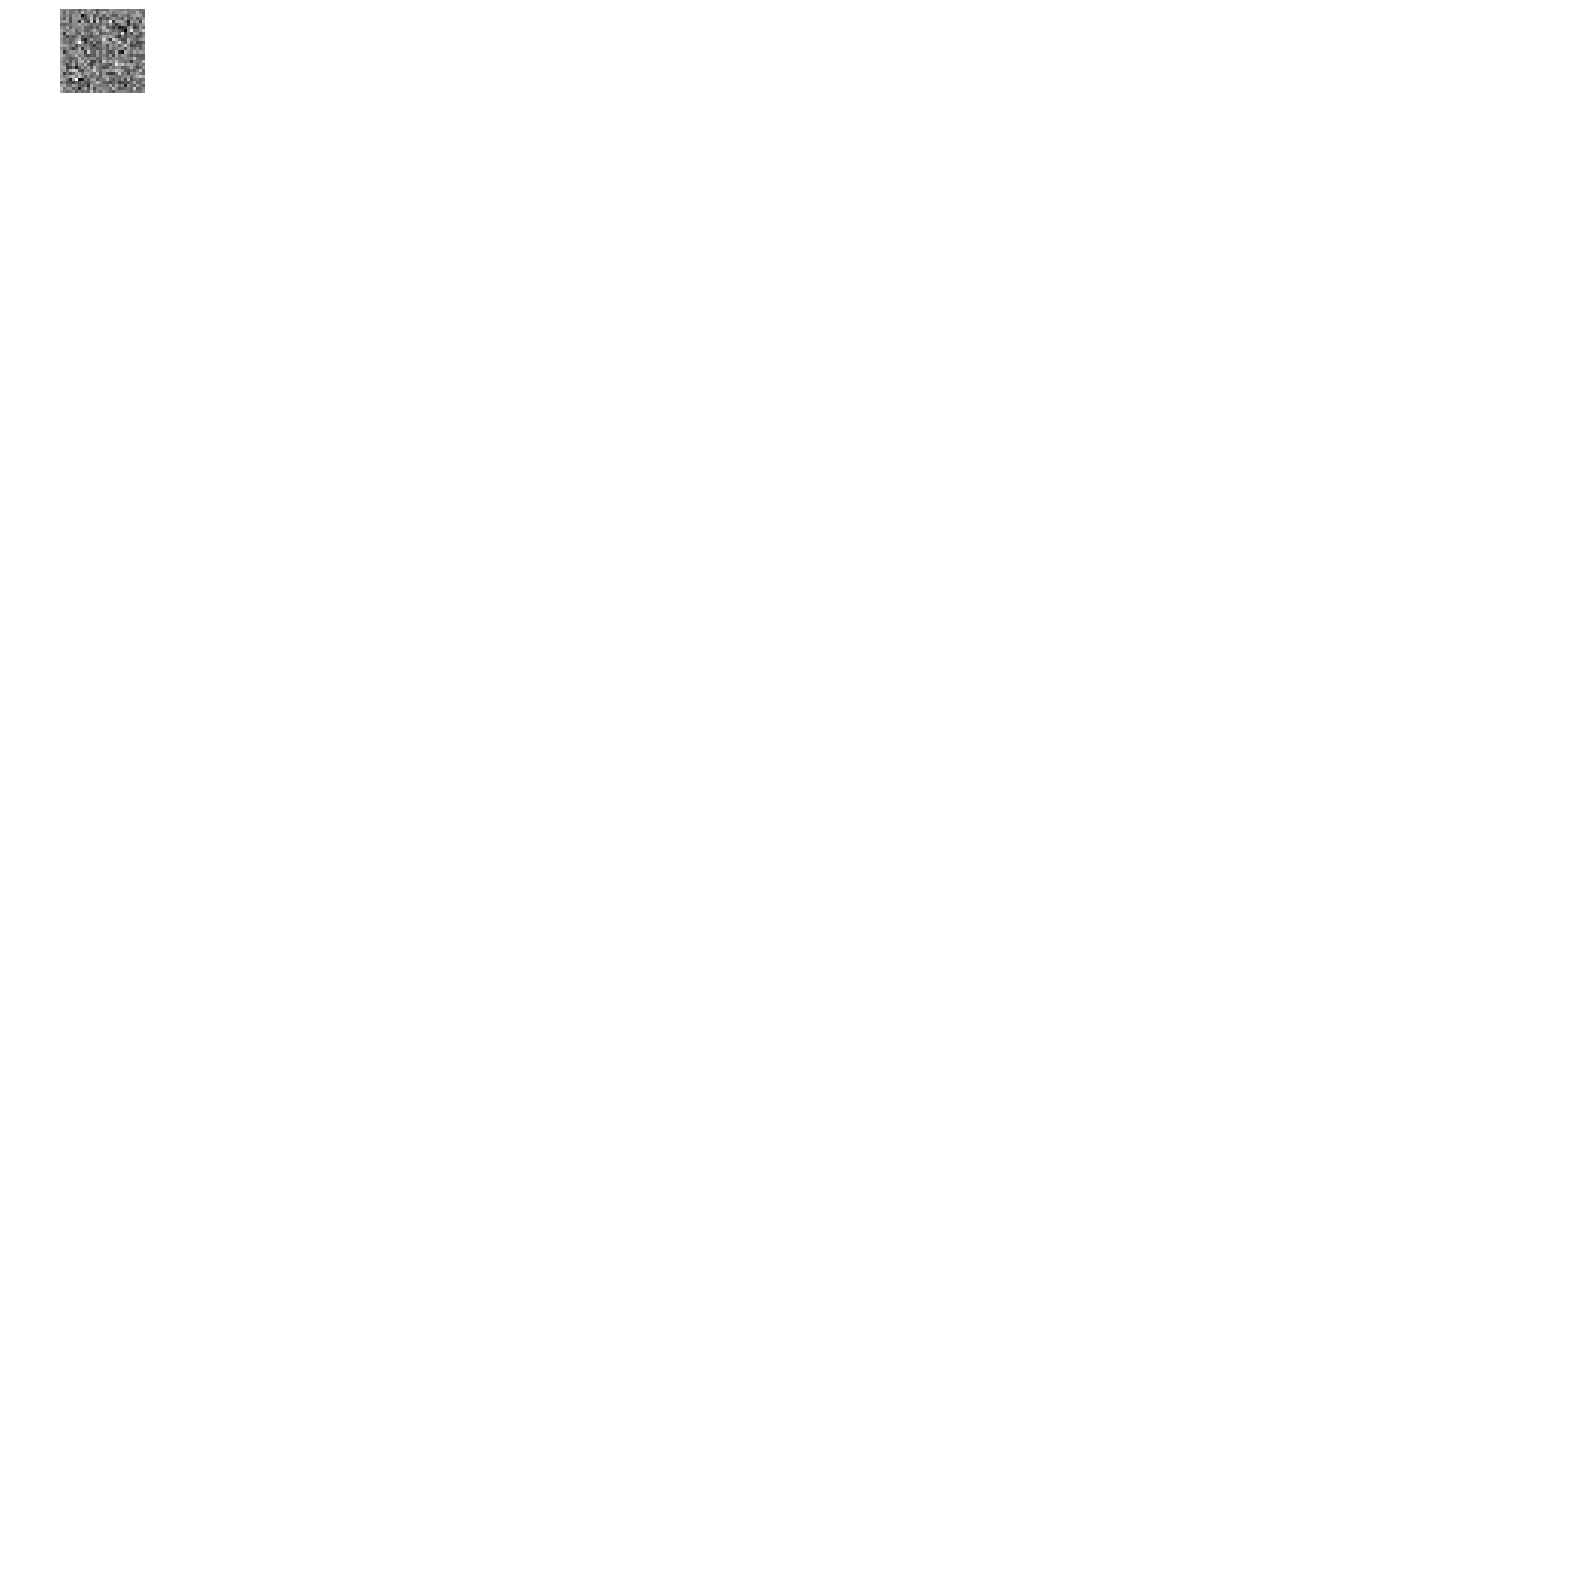

In [68]:
in_channels = 1

up3_m1 = nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1)
up3_m2 = nn.GroupNorm(8, n_feat)
up3_m3 = nn.ReLU()
up3_m4 = nn.Conv2d(n_feat, in_channels, 3, 1, 1)

up3_cat_x = torch.cat((up3, init_conv), 1)
print("up3_cat_x.shape:", up3_cat_x.shape)
channel_visualization("", up3_cat_x)

out = up3_m1(up3_cat_x)
print("out Conv2d(256 -> 128):", out) 
channel_visualization("", out)

out = up3_m2(out)
print("out GroupNorm:", out) 
channel_visualization("", out)

out = up3_m3(out)
print("out ReLU:", out) 
channel_visualization("", out)

out = up3_m4(out)
print("out Conv2d(128 -> 1):", out) 
channel_visualization("", out)

### For models where all weights are learned

### Distribution of the Training Data

### Distribution of the Model's Output